In [524]:
import os
import pandas as pd
import numpy as np
import torch
import plotly.express as px
import plotly.graph_objs as go
import plotly.colors
from scipy.stats import ttest_ind_from_stats

from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from umap import UMAP

from src.ModelUtils import (load_model,
                            train_model,
                            save_model_losses,
                            load_and_plot_losses)
from src.DataUtils import (load_data_from_directory,
                           segment_all_steps,
                           steps_to_tensor,
                           reshape_data)
from src.Plot import (plot_step_trajectory, plot_trajectory,
                      plot_animated_trajectory, plot_trajectory_with_joint_traces,
                      compare_step_features_in_batches, plot_umap_from_step,
                      plot_umap_all_steps, plot_mean_spatial_trajectory,
                      compare_phase_aligned_average_single, compare_phase_aligned_average_xy,
                      plot_phase_aligned_average_single, plot_phase_aligned_average_xy,
                      plot_trajectory_with_joint_trace,
                      compare_spatial_progression_over_time, compare_spatial_progression_xy_over_time,
                      compare_spatial_angle_progression_over_time)

In [538]:
## Directories and constants
FIGURES_DIR = './figures/NewEpilepsy'
MODELS_DIR = './src/models'
DATA_DIR = r'C:\Users\walid\Desktop\Work\Thesis\AnalysisFeatures\EpilepsyFeatures\Time'
MEAN_FEATURES_FILE = r'C:\Users\walid\Desktop\Work\Thesis\AnalysisFeatures\EpilepsyFeatures\Mouse\FullEpilepsy_hindlimb_mouse_features_2025-06-19_18-22-04.csv' # updated means and circular means
FORELIMB_MEANS_FILE = r'C:\Users\walid\Desktop\Work\Thesis\AnalysisFeatures\EpilepsyFeatures\Mouse\FullEpilepsy_forelimb_mouse_features_2025-06-19_18-22-04.csv' # updated means and circular means
# MEAN_FEATURES_FILE = './csv/SCI_pre_acute_hindlimb_mouse_features_2025-06-06_15-11-59.csv'
# MEAN_FEATURES_FILE = './csv/sideview_hindlimb_mouse_features_new_H.csv'
HEALTHY_KEY = 'MUNonTreated'
SICK_KEY = 'WTNonTreated'
SIDE_KEY = ('','Right')

## Hyperparameters and early stopping
INPUT_DIM = None
HIDDEN_DIM = 64
LATENT_DIM = 16
BATCH_SIZE = 32
NUM_EPOCHS = 5000
LR = 1e-3
PATIENCE = 100 # number of epochs to wait for improvement before stopping
MIN_DELTA = 1e-4 # minimum change to qualify as an improvement
BEST_MODEL_PATH = os.path.join(MODELS_DIR, 'lstm_VAE_t_SCI_20250609_200452.pt')
BEST_LOSS_PATH = os.path.join(FIGURES_DIR, 'SCI_losses.csv')

## Plot constants
SCATTER_SIZE = 6
SCATTER_LINE_WIDTH = 1
SCATTER_SYMBOL = 'circle'
LEGEND_FONT_SIZE = 18
TITLE_FONT_SIZE = 24
AXIS_FONT_SIZE = 16
AXIS_TITLE_FONT_SIZE = 20

# Load the data
data = load_data_from_directory(DATA_DIR)

# Print the data structure
for datagroup, mice in data.items():
    print(f"Group: {datagroup}")
    for mouse_direction, runs in mice.items():
        print(f"\t{mouse_direction}: {len(runs)} runs with shapes: {[df.shape for df in runs.values()]}")

Group: MUCX_Epilepsy
	Mouse1Cage1_Left: 3 runs with shapes: [(217, 246), (139, 246), (172, 246)]
	Mouse1Cage1_Right: 3 runs with shapes: [(292, 246), (191, 246), (193, 246)]
	Mouse1Cage3_Left: 3 runs with shapes: [(133, 246), (124, 246), (135, 246)]
	Mouse1Cage3_Right: 3 runs with shapes: [(136, 246), (158, 246), (104, 246)]
	Mouse2Cage1_Left: 3 runs with shapes: [(161, 246), (235, 246), (139, 246)]
	Mouse2Cage1_Right: 3 runs with shapes: [(141, 246), (171, 246), (158, 246)]
	Mouse2Cage2_Left: 4 runs with shapes: [(195, 246), (112, 246), (135, 246), (241, 246)]
	Mouse2Cage2_Right: 5 runs with shapes: [(171, 246), (161, 246), (158, 246), (235, 246), (181, 246)]
	Mouse2Cage3_Left: 3 runs with shapes: [(171, 246), (201, 246), (135, 246)]
	Mouse2Cage3_Right: 3 runs with shapes: [(161, 246), (115, 246), (100, 246)]
	Mouse3Cage2_Left: 5 runs with shapes: [(242, 246), (103, 246), (96, 246), (261, 246), (221, 246)]
	Mouse3Cage2_Right: 4 runs with shapes: [(299, 246), (174, 246), (107, 246), (1

In [ ]:
# Print the features count
for datagroup, mice in data.items():
    for mouse_direction, runs in mice.items():
        for run, df in runs.items():
            print(f"Number of features: {df.shape[1] + 1 - 4}") # +1 bc of index, -4 to exclude frame, forestep, hindstep, and time
            break
        break
    break

Number of features: 243


In [ ]:
## Segment all steps in the data
# This will create two dictionaries: segmented_hindsteps and segmented_foresteps
# Each dictionary will contain segmented steps for each mouse direction and run
    # "step": step_df,
    # "group": group,
    # "mouse": mouse,
    # "run": run
segmented_hindsteps, segmented_foresteps = segment_all_steps(data)

reshaped_data = reshape_data(data) # reshape the data to have a single DataFrame for each mouse direction and run and access to the hindsteps and foresteps

## Flatten all steps into a single array to compute global mean/std and get the scaler
all_healthy_arrays = [step_dict["step"].values for step_dict in segmented_hindsteps if HEALTHY_KEY in step_dict["group"] and SIDE_KEY[0] in step_dict["mouse"]]
flat_data = np.vstack(all_healthy_arrays)

scaler = StandardScaler()
scaler = scaler.fit(flat_data)

## Prepare the data for training
healthy_steps = [s for s in segmented_hindsteps if HEALTHY_KEY in s["group"] and SIDE_KEY[0] in s["mouse"]]
healthy_foresteps = [s for s in segmented_foresteps if HEALTHY_KEY in s["group"] and SIDE_KEY[0] in s["mouse"]]
unhealthy_steps = [s for s in segmented_hindsteps if SICK_KEY in s["group"] and SIDE_KEY[0] in s["mouse"]]
unhealthy_foresteps = [s for s in segmented_foresteps if SICK_KEY in s["group"] and SIDE_KEY[0] in s["mouse"]]
step_tensor, lengths = steps_to_tensor(healthy_steps, scaler)
if INPUT_DIM is None:
    INPUT_DIM = step_tensor.shape[2]

print(f"Number of healthy steps: {len(healthy_steps)}")
print(f"Number of unhealthy steps: {len(unhealthy_steps)}")
print(f"Number of healthy foresteps: {len(healthy_foresteps)}")
print(f"Number of unhealthy foresteps: {len(unhealthy_foresteps)}")

Number of healthy steps: 91
Number of unhealthy steps: 113
Number of healthy foresteps: 89
Number of unhealthy foresteps: 113


In [ ]:
print(f'Segmented dataframe shape: {segmented_hindsteps[0]["step"].shape}')
#print(f'Averaged dataframe shhape: {averaged_hindsteps[0]["step"].shape}')
print(f"Step tensor shape: {step_tensor.shape}, \nLengths shape: {lengths.shape}")

Segmented dataframe shape: (60, 244)
Step tensor shape: torch.Size([91, 93, 244]), 
Lengths shape: torch.Size([91])


In [ ]:
### Plot XY pose data
HINDLIMB_KEY = 'hindlimb'
FORELIMB_KEY = 'forelimb'
SPINE_KEY = 'spine'
TAIL_KEY = 'tail'
POSE_KEY = 'pose'
ANGLE_KEY = 'Angle'
PHASE_KEY = 'Phase'
ALL_LIMBS = [HINDLIMB_KEY, FORELIMB_KEY, SPINE_KEY, TAIL_KEY]
first_df = next(iter(segmented_hindsteps))["step"]

In [ ]:
## Extract poses for each limb
hindlimb_keys = [key for key in first_df.columns if HINDLIMB_KEY in key and POSE_KEY in key]
forelimb_keys = [key for key in first_df.columns if FORELIMB_KEY in key and POSE_KEY in key]
spine_keys = [key for key in first_df.columns if SPINE_KEY in key and POSE_KEY in key]
tail_keys = [key for key in first_df.columns if TAIL_KEY in key and POSE_KEY in key]

all_limbs_keys = [hindlimb_keys, forelimb_keys, spine_keys, tail_keys]
for limb in all_limbs_keys:
    print(f"Limbs poses: {limb}")

Limbs poses: ['rhindlimb hip - X pose (m)', 'rhindlimb hip - Y pose (m)', 'rhindlimb knee - X pose (m)', 'rhindlimb knee - Y pose (m)', 'rhindlimb ankle - X pose (m)', 'rhindlimb ankle - Y pose (m)', 'rhindlimb lHindpaw - X pose (m)', 'rhindlimb lHindpaw - Y pose (m)', 'rhindlimb lHindfingers - X pose (m)', 'rhindlimb lHindfingers - Y pose (m)']
Limbs poses: ['rforelimb shoulder - X pose (m)', 'rforelimb shoulder - Y pose (m)', 'rforelimb elbow - X pose (m)', 'rforelimb elbow - Y pose (m)', 'rforelimb wrist - X pose (m)', 'rforelimb wrist - Y pose (m)', 'rforelimb lForepaw - X pose (m)', 'rforelimb lForepaw - Y pose (m)']
Limbs poses: ['spine head - X pose (m)', 'spine head - Y pose (m)', 'spine spine 1 - X pose (m)', 'spine spine 1 - Y pose (m)', 'spine spine 2 - X pose (m)', 'spine spine 2 - Y pose (m)', 'spine spine 3 - X pose (m)', 'spine spine 3 - Y pose (m)', 'spine spine 4 - X pose (m)', 'spine spine 4 - Y pose (m)', 'spine base - X pose (m)', 'spine base - Y pose (m)']
Limbs po

In [ ]:
## Extract angles for each limb
hindlimb_angles = [key for key in first_df.columns if ANGLE_KEY in key and HINDLIMB_KEY in key]
forelimb_angles = [key for key in first_df.columns if ANGLE_KEY in key and FORELIMB_KEY in key]
spine_angles = [key for key in first_df.columns if ANGLE_KEY in key and SPINE_KEY in key]
tail_angles = [key for key in first_df.columns if ANGLE_KEY in key and TAIL_KEY in key]

all_limbs_angles = [hindlimb_angles, forelimb_angles, spine_angles, tail_angles]
for limb in all_limbs_angles:
    print(f"Limbs angles: {limb}")

Limbs angles: ['Angle - rhindlimb - hip (°)', 'Angle - rhindlimb - knee (°)', 'Angle - rhindlimb - ankle (°)', 'Angle - rhindlimb - lHindpaw (°)', 'Angle - rhindlimb - lHindfingers (°)', 'Angle velocity - rhindlimb - hip (rad/s)', 'Angle velocity - rhindlimb - knee (rad/s)', 'Angle velocity - rhindlimb - ankle (rad/s)', 'Angle velocity - rhindlimb - lHindpaw (rad/s)', 'Angle velocity - rhindlimb - lHindfingers (rad/s)', 'Angle acceleration - rhindlimb - hip (rad/s^2)', 'Angle acceleration - rhindlimb - knee (rad/s^2)', 'Angle acceleration - rhindlimb - ankle (rad/s^2)', 'Angle acceleration - rhindlimb - lHindpaw (rad/s^2)', 'Angle acceleration - rhindlimb - lHindfingers (rad/s^2)']
Limbs angles: ['Angle - rforelimb - shoulder (°)', 'Angle - rforelimb - elbow (°)', 'Angle - rforelimb - wrist (°)', 'Angle - rforelimb - lForepaw (°)', 'Angle velocity - rforelimb - shoulder (rad/s)', 'Angle velocity - rforelimb - elbow (rad/s)', 'Angle velocity - rforelimb - wrist (rad/s)', 'Angle velocity

In [ ]:
## Extract phases for each limb
hindlimb_phase = [key for key in first_df.columns if PHASE_KEY in key and HINDLIMB_KEY in key]
forelimb_phase = [key for key in first_df.columns if PHASE_KEY in key and FORELIMB_KEY in key]
spine_phase = [key for key in first_df.columns if PHASE_KEY in key and SPINE_KEY in key]
tail_phase = [key for key in first_df.columns if PHASE_KEY in key and TAIL_KEY in key]

all_limbs_phase = [hindlimb_phase, forelimb_phase, spine_phase, tail_phase]
for limb in all_limbs_phase:
    print(f"Limbs phases: {limb}")

Limbs phases: ['Phase - rhindlimb - hip (°)', 'Phase - rhindlimb - knee (°)', 'Phase - rhindlimb - ankle (°)', 'Phase - rhindlimb - lHindpaw (°)', 'Phase velocity - rhindlimb - hip (rad/s)', 'Phase velocity - rhindlimb - knee (rad/s)', 'Phase velocity - rhindlimb - ankle (rad/s)', 'Phase velocity - rhindlimb - lHindpaw (rad/s)', 'Phase acceleration - rhindlimb - hip (rad/s^2)', 'Phase acceleration - rhindlimb - knee (rad/s^2)', 'Phase acceleration - rhindlimb - ankle (rad/s^2)', 'Phase acceleration - rhindlimb - lHindpaw (rad/s^2)']
Limbs phases: ['Phase - rforelimb - shoulder (°)', 'Phase - rforelimb - elbow (°)', 'Phase - rforelimb - wrist (°)', 'Phase velocity - rforelimb - shoulder (rad/s)', 'Phase velocity - rforelimb - elbow (rad/s)', 'Phase velocity - rforelimb - wrist (rad/s)', 'Phase acceleration - rforelimb - shoulder (rad/s^2)', 'Phase acceleration - rforelimb - elbow (rad/s^2)', 'Phase acceleration - rforelimb - wrist (rad/s^2)']
Limbs phases: ['Phase - spine - head (°)', '

In [ ]:
## Extract CoM features
CoM_features = [key for key in first_df.columns if 'CoM' in key in key]
print(f"CoM features: {CoM_features}")

CoM features: ['rforelimb - CoM X (m)', 'rforelimb - CoM Y (m)', 'rhindlimb - CoM X (m)', 'rhindlimb - CoM Y (m)', 'spine - CoM X (m)', 'spine - CoM Y (m)', 'tail - CoM X (m)', 'tail - CoM Y (m)']


In [ ]:
## Extract relevant single point features
hindfinger_features = [key for key in first_df.columns if 'hindfingers' in key.lower() and 'Angle' not in key]
hindpaw_features = [key for key in first_df.columns if 'hindpaw' in key.lower() and 'Angle' not in key]
forepaw_features = [key for key in first_df.columns if 'forepaw' in key.lower() and 'Angle' not in key]
head_features = [key for key in first_df.columns if 'head' in key.lower() and 'Angle' not in key]
knee_features = [key for key in first_df.columns if 'knee' in key.lower() and 'Angle' not in key]

single_point_features = [hindfinger_features, hindpaw_features, forepaw_features, head_features, knee_features]
single_point_feature_names = ['hindfingers', 'hindpaw', 'forepaw', 'head', 'knee']
for features in single_point_features:
    print(f"Single point features: {features}")

Single point features: ['rhindlimb lHindfingers - X pose (m)', 'rhindlimb lHindfingers - X velocity (m/s)', 'rhindlimb lHindfingers - X acceleration (m/s^2)', 'rhindlimb lHindfingers - X jerk (m/s^3)', 'rhindlimb lHindfingers - Y pose (m)', 'rhindlimb lHindfingers - Y velocity (m/s)', 'rhindlimb lHindfingers - Y acceleration (m/s^2)', 'rhindlimb lHindfingers - Y jerk (m/s^3)']
Single point features: ['rhindlimb lHindpaw - X pose (m)', 'rhindlimb lHindpaw - X velocity (m/s)', 'rhindlimb lHindpaw - X acceleration (m/s^2)', 'rhindlimb lHindpaw - X jerk (m/s^3)', 'rhindlimb lHindpaw - Y pose (m)', 'rhindlimb lHindpaw - Y velocity (m/s)', 'rhindlimb lHindpaw - Y acceleration (m/s^2)', 'rhindlimb lHindpaw - Y jerk (m/s^3)', 'Phase - rhindlimb - lHindpaw (°)', 'Phase velocity - rhindlimb - lHindpaw (rad/s)', 'Phase acceleration - rhindlimb - lHindpaw (rad/s^2)']
Single point features: ['rforelimb lForepaw - X pose (m)', 'rforelimb lForepaw - X velocity (m/s)', 'rforelimb lForepaw - X accelera

In [ ]:
## Save all angle plots
savedir = os.path.join(FIGURES_DIR, 'Angles')
# Make sure the directory exists
os.makedirs(savedir, exist_ok=True)

for limb, angles in zip(ALL_LIMBS, all_limbs_angles):
    plot_phase_aligned_average_single(healthy_steps, feature_keys=angles, figure_path=os.path.join(savedir, f'Angles_healthy_time_locked_{limb}.svg')) # Plot phase locked for one state
    compare_phase_aligned_average_single(healthy_steps, unhealthy_steps, feature_keys=angles, figure_path=os.path.join(savedir, f'Angles_healthy_vs_SCI_time_locked_{limb}.svg')) # Plot phase locked for two states
    compare_spatial_angle_progression_over_time(healthy_steps, unhealthy_steps, feature_keys=angles, figure_path=os.path.join(savedir, f'Angles_healthy_vs_SCI_space_locked_{limb}.svg')) # Plot space locked for two states

In [ ]:
forestep_dir = os.path.join(FIGURES_DIR, 'Angles/Foresteps')
# Make sure the directory exists
os.makedirs(forestep_dir, exist_ok=True)

for limb, angles in zip(ALL_LIMBS, all_limbs_angles):
    plot_phase_aligned_average_single(healthy_foresteps, feature_keys=angles, figure_path=os.path.join(forestep_dir, f'Angles_healthy_time_locked_{limb}.svg')) # Plot phase locked for one state
    compare_phase_aligned_average_single(healthy_foresteps, unhealthy_foresteps, feature_keys=angles, figure_path=os.path.join(forestep_dir, f'Angles_healthy_vs_SCI_time_locked_{limb}.svg')) # Plot phase locked for two states
    compare_spatial_angle_progression_over_time(healthy_foresteps, unhealthy_foresteps, feature_keys=angles, figure_path=os.path.join(forestep_dir, f'Angles_healthy_vs_SCI_space_locked_{limb}.svg')) # Plot space locked for two states

In [ ]:
## Save all phase plots
savedir = os.path.join(FIGURES_DIR, 'Phases')
# Make sure the directory exists
os.makedirs(savedir, exist_ok=True)

for limb, phases in zip(ALL_LIMBS, all_limbs_phase):
    plot_phase_aligned_average_single(healthy_steps, feature_keys=phases, figure_path=os.path.join(savedir, f'Phases_healthy_time_locked_{limb}.svg')) # Plot phase locked for one state
    compare_phase_aligned_average_single(healthy_steps, unhealthy_steps, feature_keys=phases, figure_path=os.path.join(savedir, f'Phases_healthy_vs_SCI_time_locked_{limb}.svg')) # Plot phase locked for two states
    compare_spatial_angle_progression_over_time(healthy_steps, unhealthy_steps, feature_keys=angles, figure_path=os.path.join(savedir, f'Phases_healthy_vs_SCI_space_locked_{limb}.svg')) # Plot space locked for two states

In [ ]:
forestep_dir = os.path.join(FIGURES_DIR, 'Phases/Foresteps')
# Make sure the directory exists
os.makedirs(forestep_dir, exist_ok=True)

for limb, phases in zip(ALL_LIMBS, all_limbs_phase):
    plot_phase_aligned_average_single(healthy_foresteps, feature_keys=phases, figure_path=os.path.join(forestep_dir, f'Phases_healthy_time_locked_{limb}.svg')) # Plot phase locked for one state
    compare_phase_aligned_average_single(healthy_foresteps, unhealthy_foresteps, feature_keys=phases, figure_path=os.path.join(forestep_dir, f'Phases_healthy_vs_SCI_time_locked_{limb}.svg')) # Plot phase locked for two states
    compare_spatial_angle_progression_over_time(healthy_foresteps, unhealthy_foresteps, feature_keys=angles, figure_path=os.path.join(forestep_dir, f'Phases_healthy_vs_SCI_space_locked_{limb}.svg')) # Plot space locked for two states

In [ ]:
## Save all CoM plots
savedir = os.path.join(FIGURES_DIR, 'CoM')
# Make sure the directory exists
os.makedirs(savedir, exist_ok=True)

plot_phase_aligned_average_xy(healthy_steps, feature_keys=CoM_features, figure_path=os.path.join(savedir, 'CoM_healthy_time_locked.svg')) # Plot phase locked for one state
compare_phase_aligned_average_xy(healthy_steps, unhealthy_steps, feature_keys=CoM_features, figure_path=os.path.join(savedir, 'CoM_healthy_vs_SCI_time_locked.svg')) # Plot phase locked for two states
compare_spatial_progression_xy_over_time(healthy_steps, unhealthy_steps, feature_keys=CoM_features, length_key='rhindlimb lHindfingers - X pose (m)', height_key='rhindlimb lHindfingers - Y pose (m)', figure_path=os.path.join(savedir, 'CoM_healthy_vs_SCI_space_locked.svg')) # Plot space locked for two states

In [ ]:
forestep_dir = os.path.join(FIGURES_DIR, 'CoM/Foresteps')
# Make sure the directory exists
os.makedirs(forestep_dir, exist_ok=True)

plot_phase_aligned_average_xy(healthy_foresteps, feature_keys=CoM_features, figure_path=os.path.join(forestep_dir, 'CoM_healthy_time_locked.svg')) # Plot phase locked for one state
compare_phase_aligned_average_xy(healthy_foresteps, unhealthy_foresteps, feature_keys=CoM_features, figure_path=os.path.join(forestep_dir, 'CoM_healthy_vs_SCI_time_locked.svg')) # Plot phase locked for two states
compare_spatial_progression_xy_over_time(healthy_foresteps, unhealthy_foresteps, feature_keys=CoM_features, length_key='rforelimb lForepaw - X pose (m)', height_key='rforelimb lForepaw - Y pose (m)', figure_path=os.path.join(forestep_dir, 'CoM_healthy_vs_SCI_space_locked.svg')) # Plot space locked for two states

In [ ]:
## Save all XY pose plots
savedir = os.path.join(FIGURES_DIR, 'Kinematics')
# Make sure the directory exists
os.makedirs(savedir, exist_ok=True)

for name, feature in zip(single_point_feature_names, single_point_features):
    plot_phase_aligned_average_xy(healthy_steps, feature_keys=feature, figure_path=os.path.join(savedir, f'{name}_healthy_time_locked.svg')) # Plot phase locked for one state
    compare_phase_aligned_average_xy(healthy_steps, unhealthy_steps, feature_keys=feature, figure_path=os.path.join(savedir, f'{name}_healthy_vs_SCI_time_locked.svg')) # Plot phase locked for two states
    compare_spatial_progression_xy_over_time(healthy_steps, unhealthy_steps, feature_keys=feature, length_key='rhindlimb lHindfingers - X pose (m)', height_key='rhindlimb lHindfingers - Y pose (m)', figure_path=os.path.join(savedir, f'{name}_healthy_vs_SCI_space_locked.svg')) # Plot space locked for two states

In [ ]:
forestep_dir = os.path.join(FIGURES_DIR, 'Kinematics/Foresteps')
# Make sure the directory exists
os.makedirs(forestep_dir, exist_ok=True)

for name, feature in zip(single_point_feature_names, single_point_features):
    plot_phase_aligned_average_xy(healthy_foresteps, feature_keys=feature, figure_path=os.path.join(forestep_dir, f'{name}_healthy_time_locked.svg')) # Plot phase locked for one state
    compare_phase_aligned_average_xy(healthy_foresteps, unhealthy_foresteps, feature_keys=feature, figure_path=os.path.join(forestep_dir, f'{name}_healthy_vs_SCI_time_locked.svg')) # Plot phase locked for two states
    compare_spatial_progression_xy_over_time(healthy_foresteps, unhealthy_foresteps, feature_keys=feature, length_key='rforelimb lForepaw - X pose (m)', height_key='rforelimb lForepaw - Y pose (m)', figure_path=os.path.join(forestep_dir, f'{name}_healthy_vs_SCI_space_locked.svg')) # Plot space locked for two states

In [ ]:
forelimb_keys = [key for key in first_df.columns if 'forelimb' in key.lower() and POSE_KEY in key]
# Plot stick figure forelimb (bottom) and hindlimb (upper) trajectories
savedir = os.path.join(FIGURES_DIR, 'Trajectories/Full')
# Make sure the directory exists
os.makedirs(savedir, exist_ok=True)

plot_trajectory_with_joint_traces(reshaped_data, forelimb_keys, hindlimb_keys, figure_path=savedir)

In [ ]:
# time is nornmalized by step
fig = plot_mean_spatial_trajectory(segmented_hindsteps) 

# fig.write_image(os.path.join('/home/filthyweeb/Downloads', 'xy'), format='svg')

In [ ]:
plot_umap_from_step(segmented_hindsteps[0])

c:\Users\walid\Desktop\Work\DataAnalysis\MScThesis\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
plot_umap_all_steps(healthy_steps)

c:\Users\walid\Desktop\Work\DataAnalysis\MScThesis\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
plot_umap_all_steps(unhealthy_steps)

c:\Users\walid\Desktop\Work\DataAnalysis\MScThesis\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
compare_step_features_in_batches(segmented_hindsteps[0])

Saved: ./figures/SCI\Mouse1Cage1_Left_Run3_feature_pairs_batch_1.html
Saved: ./figures/SCI\Mouse1Cage1_Left_Run3_feature_pairs_batch_2.html
Saved: ./figures/SCI\Mouse1Cage1_Left_Run3_feature_pairs_batch_3.html
Saved: ./figures/SCI\Mouse1Cage1_Left_Run3_feature_pairs_batch_4.html
Saved: ./figures/SCI\Mouse1Cage1_Left_Run3_feature_pairs_batch_5.html
Saved: ./figures/SCI\Mouse1Cage1_Left_Run3_feature_pairs_batch_6.html
Saved: ./figures/SCI\Mouse1Cage1_Left_Run3_feature_pairs_batch_7.html
Saved: ./figures/SCI\Mouse1Cage1_Left_Run3_feature_pairs_batch_8.html
Saved: ./figures/SCI\Mouse1Cage1_Left_Run3_feature_pairs_batch_9.html
Saved: ./figures/SCI\Mouse1Cage1_Left_Run3_feature_pairs_batch_10.html
Saved: ./figures/SCI\Mouse1Cage1_Left_Run3_feature_pairs_batch_11.html
Saved: ./figures/SCI\Mouse1Cage1_Left_Run3_feature_pairs_batch_12.html
Saved: ./figures/SCI\Mouse1Cage1_Left_Run3_feature_pairs_batch_13.html
Saved: ./figures/SCI\Mouse1Cage1_Left_Run3_feature_pairs_batch_14.html
Saved: ./figure

In [ ]:
plot_step_trajectory(segmented_hindsteps, hindlimb_keys)

In [ ]:
plot_trajectory_with_joint_trace(reshaped_data, hindlimb_keys)

In [ ]:
com_keys = [key for key in first_df.columns if 'CoM' in key]
print(f"CoM keys: {com_keys}")
plot_trajectory_with_joint_trace(reshaped_data, com_keys)

CoM keys: ['rforelimb - CoM X (m)', 'rforelimb - CoM Y (m)', 'rhindlimb - CoM X (m)', 'rhindlimb - CoM Y (m)', 'spine - CoM X (m)', 'spine - CoM Y (m)', 'tail - CoM X (m)', 'tail - CoM Y (m)']


In [ ]:
plot_animated_trajectory(reshaped_data, hindlimb_keys)

In [ ]:
plot_trajectory(reshaped_data, hindlimb_keys)

In [ ]:
## Plt one step for xy pose
compare_spatial_progression_over_time(healthy_steps, unhealthy_steps, finger_pose_key='rhindlimb lHindfingers - X pose (m)')

# Check for mean features

In [539]:
## Check step features vs velocity 
# features_to_check = ('Mean step height (m)', 'Mean step length (m)', 'Mean step duration (s)', 'Mean swing duration (s)', 'Mean stance duration (s)', 'Mean step frequency (Hz)')
# foresteps_features_to_check = ('Mean angle excursion - rhindlimb - knee (°)', 'Mean angle excursion - rhindlimb - ankle (°)', 'Mean phase excursion - rhindlimb - hip (°)', 'Mean phase excursion - rhindlimb - knee (°)', 'Mean phase excursion - rhindlimb - ankle (°)', 'Mean phase excursion - rhindlimb - lHindpaw (°)')
# features_to_check_against = ('Mean step velocity X at stance - lHindpaw (m/s)', 'Mean step velocity Y at stance - lHindpaw (m/s)', 'Mean step velocity X at swing - lHindpaw (m/s)', 'Mean step velocity Y at swing - lHindpaw (m/s)')
# features_to_check_against = ('Mean step velocity X at stance - lHindfingers (m/s)', 'Mean step velocity Y at stance - lHindfingers (m/s)', 'Mean step velocity X at swing - lHindfingers (m/s)', 'Mean step velocity Y at swing - lHindfingers (m/s)')

# features_to_check = ('Mean phase excursion - rhindlimb - ankle (°)',)
# features_to_check_against = ('Mean step velocity Y at stance - lHindpaw (m/s)',)

features_to_check = ('Mean angle during swing - rforelimb - shoulder (°)',
                    'Mean angle during swing - rhindlimb - ankle (°)',
                    'Mean phase during swing - spine - spine 1 (°)',
                    'Mean angle during swing - rforelimb - wrist (°)',
                    'Mean phase during swing - rforelimb - shoulder (°)')
features_to_check_against = ('Mean phase during stance - spine - spine 1 (°)',
                            'Mean phase during stance - rforelimb - wrist (°)',
                            'Mean angle during stance - rforelimb - lForepaw (°)',
                            'Mean step jerk Y during stance - wrist (m/s^3)',
                            'Mean angle excursion - rforelimb - wrist (°))')

foresteps_features_to_check = features_to_check

# 55 features
mu_wt_non_treated_features = ('Mean angle during swing - rhindlimb - ankle (°)', 'Mean angle during swing - rhindlimb - knee (°)', 'Mean angle excursion - tail - tail 4 (°)', 'Mean phase during swing - tail - base (°)', 'Mean step height (m)', 'Mean phase during stance - tail - base (°)', 'Mean angle during stance - tail - tail 1 (°)', 'Mean propulsion vector angle (°)', 'Mean step velocity Y during swing - knee (m/s)', 'Mean phase during stance - spine - spine 1 (°)', 'Mean angle excursion - spine - spine 4 (°)', 'Mean phase during swing - rhindlimb - ankle (°)', 'Mean angle excursion - rforelimb - wrist (°)', 'Mean angle during stance - tail - tail 4 (°)', 'Mean angle during swing - rforelimb - wrist (°)', 'Mean angle during swing - tail - tail 4 (°)', 'Mean angle during swing - rforelimb - lForepaw (°)', 'Mean step velocity Y during stance - knee (m/s)', 'Mean phase during swing - rforelimb - wrist (°)', 'Mean angle excursion - tail - tail 2 (°)', 'Mean angle excursion - tail - tail 3 (°)', 'Mean angle velocity during swing - rhindlimb - knee (rad/s)', 'Mean phase during swing - rhindlimb - lHindpaw (°)', 'Mean angle during swing - rhindlimb - hip (°)', 'Mean phase during swing - rhindlimb - hip (°)', 'Mean angle velocity - tail - tail 2 (rad/s)', 'Mean phase during stance - tail - tail 1 (°)', 'Mean phase during stance - spine - spine 2 (°)', 'Mean phase during swing - spine - spine 1 (°)', 'Mean angle excursion - tail - tail 1 (°)', 'Mean angle during swing - rhindlimb - lHindfingers (°)', 'Mean angle velocity during swing - spine - spine 2 (rad/s)', 'Mean phase during swing - tail - tail 1 (°)', 'Mean angle velocity during swing - spine - spine 3 (rad/s)', 'Mean phase velocity during swing - spine - spine 3 (rad/s)', 'Mean phase excursion - tail - tail 3 (°)', 'Mean phase excursion - rforelimb - wrist (°)', 'Mean angle velocity - tail - tail 1 (rad/s)', 'Mean angle velocity during swing - tail - tail 4 (rad/s)', 'Mean phase excursion - spine - spine 2 (°)', 'Mean angle during stance - rforelimb - lForepaw (°)', 'Mean phase during stance - rforelimb - wrist (°)', 'Mean angle excursion - spine - head (°)', 'Mean phase excursion - spine - head (°)', 'Mean phase excursion - rhindlimb - knee (°)', 'Mean angle during stance - rhindlimb - knee (°)', 'Mean phase excursion - rhindlimb - lHindpaw (°)', 'Mean angle during stance - tail - tail 3 (°)', 'Mean angle excursion - rhindlimb - ankle (°)', 'Mean step jerk Y during stance - wrist (m/s^3)', 'Mean angle during stance - rhindlimb - ankle (°)', 'Mean angle excursion - rforelimb - lForepaw (°)', 'Mean angle excursion - rhindlimb - lHindfingers (°)', 'Mean angle during swing - rforelimb - shoulder (°)', 'Mean phase during swing - rforelimb - shoulder (°)')
mu_wt_non_treated_features = set(mu_wt_non_treated_features)

# 19 features
drug_recovery_features = ('Mean phase during stance - rforelimb - wrist (°)', 'Mean angle excursion - tail - tail 1 (°)', 'Mean angle velocity during swing - spine - spine 3 (rad/s)', 'Mean angle during stance - rforelimb - lForepaw (°)', 'Mean angle velocity - tail - tail 1 (rad/s)', 'Mean angle excursion - tail - tail 4 (°)', 'Mean phase during stance - tail - tail 1 (°)', 'Mean angle velocity during swing - tail - tail 4 (rad/s)', 'Mean angle during swing - rforelimb - wrist (°)', 'Mean step jerk Y during stance - wrist (m/s^3)', 'Mean phase during swing - rforelimb - shoulder (°)', 'Mean phase during stance - spine - spine 1 (°)', 'Mean phase during swing - spine - spine 1 (°)', 'Mean phase excursion - tail - tail 3 (°)', 'Mean angle during swing - rhindlimb - ankle (°)', 'Mean angle excursion - rforelimb - wrist (°)', 'Mean angle during swing - rforelimb - shoulder (°)', 'Mean phase velocity during swing - spine - spine 3 (rad/s)', 'Mean phase during swing - tail - tail 1 (°)')
drug_recovery_features = set(drug_recovery_features)

## Load the mean features
mean_features_df = pd.read_csv(MEAN_FEATURES_FILE)
print(f"Mean features shape: {mean_features_df.shape}")
print(f"Mean features columns: {set(mean_features_df['Dataset'].str.lower())}")
healthy_mean_features = mean_features_df[
    mean_features_df['Dataset'].str.lower().str.contains(HEALTHY_KEY.lower()) &
    mean_features_df['Dataset'].str.lower().str.contains(SIDE_KEY[0].lower())
]
sick_mean_features = mean_features_df[
    mean_features_df['Dataset'].str.lower().str.contains(SICK_KEY.lower()) &
    mean_features_df['Dataset'].str.lower().str.contains(SIDE_KEY[0].lower())
]
sick_mean_features_r = mean_features_df[
    mean_features_df['Dataset'].str.lower().str.contains(SICK_KEY.lower()) &
    mean_features_df['Dataset'].str.lower().str.contains(SIDE_KEY[1].lower())
]
healthy_mean_features_r = mean_features_df[
    mean_features_df['Dataset'].str.lower().str.contains(HEALTHY_KEY.lower()) &
    mean_features_df['Dataset'].str.lower().str.contains(SIDE_KEY[1].lower())
]
healthy_mean_features_lr = mean_features_df[mean_features_df['Dataset'].str.lower().str.contains(HEALTHY_KEY.lower())]
sick_mean_features_lr = mean_features_df[mean_features_df['Dataset'].str.lower().str.contains(SICK_KEY.lower())]
print(f"Healthy mean features shape: {healthy_mean_features.shape}\nSick mean features shape: {sick_mean_features.shape}")
print(f"Healthy mean features LR shape: {healthy_mean_features_lr.shape}")
print(f"Sick mean features LR shape: {sick_mean_features_lr.shape}")

forestep_mean_features_df = pd.read_csv(FORELIMB_MEANS_FILE)
healthy_forelimb_mean_features = forestep_mean_features_df[
    forestep_mean_features_df['Dataset'].str.lower().str.contains(HEALTHY_KEY.lower()) &
    forestep_mean_features_df['Dataset'].str.lower().str.contains(SIDE_KEY[0].lower())
]
sick_forelimb_mean_features = forestep_mean_features_df[
    forestep_mean_features_df['Dataset'].str.lower().str.contains(SICK_KEY.lower()) &
    forestep_mean_features_df['Dataset'].str.lower().str.contains(SIDE_KEY[0].lower())
]

print(f"Healthy forelimb mean features shape: {healthy_forelimb_mean_features.shape}\nSick forelimb mean features shape: {sick_forelimb_mean_features.shape}")

Mean features shape: (61, 2685)
Mean features columns: {'musaline', 'munontreated', 'mutreated', 'wt', 'wttreated', 'mucx', 'wtnontreated'}
Healthy mean features shape: (3, 2685)
Sick mean features shape: (8, 2685)
Healthy mean features LR shape: (3, 2685)
Sick mean features LR shape: (8, 2685)
Healthy forelimb mean features shape: (3, 2685)
Sick forelimb mean features shape: (8, 2685)


In [537]:
t_test_results_lr = defaultdict(dict)
total_features = set(healthy_mean_features_lr.columns) & set(sick_mean_features_lr.columns)
total_features.remove('Dataset')  # Remove the 'Dataset' column as it is not a feature
total_features.remove('Mouse')
for feature in total_features:
    healthy_values = healthy_mean_features_lr[feature].dropna().values
    sick_values = sick_mean_features_lr[feature].dropna().values
    if len(healthy_values) > 0 and len(sick_values) > 0:
        t_stat, p_value = ttest_ind_from_stats(
            mean1=np.mean(healthy_values),
            std1=np.std(healthy_values, ddof=1),
            nobs1=len(healthy_values),
            mean2=np.mean(sick_values),
            std2=np.std(sick_values, ddof=1),
            nobs2=len(sick_values),
            equal_var=False  # Welch's t-test
        )
        t_test_results_lr[feature]['healthy_mean'] = np.mean(healthy_values)
        t_test_results_lr[feature]['sick_mean'] = np.mean(sick_values)
        t_test_results_lr[feature]['healthy_std'] = np.std(healthy_values, ddof=1)
        t_test_results_lr[feature]['sick_std'] = np.std(sick_values, ddof=1)
        t_test_results_lr[feature]['t-statistic'] = t_stat
        t_test_results_lr[feature]['p-value'] = p_value

# Convert results to DataFrame for better readability
t_test_df_lr = pd.DataFrame(t_test_results_lr).T
t_test_df_lr = t_test_df_lr.reset_index().rename(columns={'index': 'Feature'})
t_test_df_lr['Significant'] = t_test_df_lr['p-value'] < 0.05  # Mark significant results, which indicates a significant difference between healthy and sick mice
print(f"Number of healthy mice: {len(healthy_mean_features_lr)}")
print(f"Number of sick mice: {len(sick_mean_features_lr)}")
t_test_df_lr = t_test_df_lr[~t_test_df_lr['Feature'].str.contains('at')]
t_test_df_lr = t_test_df_lr[~t_test_df_lr['Feature'].str.contains('std')]
t_test_df_lr = t_test_df_lr[~t_test_df_lr['Feature'].str.contains('std')]
t_test_df_lr = t_test_df_lr[~t_test_df_lr['Feature'].str.contains('angle value')]
t_test_df_lr = t_test_df_lr[~t_test_df_lr['Feature'].str.contains('phase value')]
t_test_df_lr = t_test_df_lr[t_test_df_lr['Significant']]
t_test_df_lr = t_test_df_lr.sort_values(by='p-value')  # Sort by p-value for better readability
# Filter out features with low variance in either group
# t_test_df_lr = t_test_df_lr[~t_test_df_lr['Feature'].str.contains('angle') & ~t_test_df_lr['Feature'].str.contains('phase')]
# t_test_df_lr = t_test_df_lr[(t_test_df_lr['healthy_std'] > 0.1) & (t_test_df_lr['sick_std'] > 0.1)]
# significant_features = t_test_df_lr[t_test_df_lr['Significant']]['Feature']
# print(significant_features)
print(f"Number of significant features: {t_test_df_lr[t_test_df_lr['Significant']].shape[0]}")
heads = t_test_df_lr.head(100)
print(f"Significant_features: {heads['Feature'].tolist()}")
print(f"Number of significant features: {heads.shape[0]}")

print()
print(heads['p-value'].min(), heads['p-value'].max())
best_features = heads['Feature'].tolist()
features_to_check = tuple(best_features)
print(f"Best features: {features_to_check}")
print(len(features_to_check))

combined_features = tuple(set(t_test_df_lr['Feature']) & set(mu_wt_non_treated_features))
print(f"Combined features: {combined_features}")
print(f"Number of combined features: {len(combined_features)}")

final_features = tuple(drug_recovery_features & set(t_test_df_lr['Feature']))
print(f"Final features: {final_features}")
print(f"Number of final features: {len(final_features)}")




Number of healthy mice: 9
Number of sick mice: 8
Number of significant features: 137
Significant_features: ['Mean angle during swing - rforelimb - shoulder (°)', 'Mean phase during swing - rforelimb - shoulder (°)', 'Mean angle during swing - rhindlimb - ankle (°)', 'Mean angle excursion - rhindlimb - hip (°)', 'Mean phase excursion - rhindlimb - hip (°)', 'Mean phase during stance - spine - spine 1 (°)', 'Mean angle during swing - rhindlimb - lHindpaw (°)', 'Mean step frequency (Hz)', 'Mean phase during swing - spine - spine 1 (°)', 'Mean angle during swing - rforelimb - wrist (°)', 'Mean phase during stance - rforelimb - wrist (°)', 'Mean angle during swing - rhindlimb - knee (°)', 'Mean angle during stance - rforelimb - lForepaw (°)', 'Mean angle during stance - spine - spine 1 (°)', 'Mean phase during swing - tail - tail 3 (°)', 'Mean angle during swing - spine - spine 1 (°)', 'Mean angle excursion - rforelimb - wrist (°)', 'Mean angle during stance - spine - spine 4 (°)', 'Mean ph

In [ ]:
angles_mask = heads['Feature'].str.contains('angle') | heads['Feature'].str.contains('phase')
angles = heads[angles_mask]

not_angles = heads[~angles_mask]
print(not_angles['Feature'].tolist())

print(f"Number of angle features: {len(angles)}")
print(f"Number of non-angle features: {len(not_angles)}")

['Mean step jerk X during stance - lHindfingers (m/s^3)', 'Mean step jerk X during stance - lHindpaw (m/s^3)', 'Mean step jerk Y during stance - hip (m/s^3)', 'Mean step velocity Y during swing - spine 2 (m/s)', 'Mean step velocity Y during stance - lHindfingers (m/s)', 'Mean step velocity Y during swing - spine 1 (m/s)', 'Mean step velocity Y during swing - lHindfingers (m/s)', 'Mean step jerk X during stance - knee (m/s^3)', 'Mean step jerk X during stance - ankle (m/s^3)', 'Mean step velocity X during swing - head (m/s)', 'Mean step velocity Y during swing - head (m/s)', 'Mean step velocity X during swing - spine 1 (m/s)', 'Mean step velocity X during stance - base (m/s)', 'Mean step velocity X during swing - spine 2 (m/s)', 'Mean step velocity X during stance - elbow (m/s)', 'Mean step velocity X during stance - spine 4 (m/s)', 'Mean step velocity X during stance - spine 3 (m/s)', 'Mean step velocity X during stance - hip (m/s)', 'Mean step velocity X during swing - shoulder (m/s)'

In [ ]:
def pre_analysis(features:pd.DataFrame):
    angles_mask = features['Feature'].str.contains('angle')

    swing_mask = features['Feature'].str.contains('swing')
    stance_mask = features['Feature'].str.contains('stance')

    hindlimb_mask = features['Feature'].str.contains('hindlimb')
    forelimb_mask = features['Feature'].str.contains('forelimb')
    tail_mask = features['Feature'].str.contains('tail')
    spine_mask = features['Feature'].str.contains('spine')

    angles = features[angles_mask]
    not_angles = features[~angles_mask]

    swing = features[swing_mask]
    stance = features[stance_mask]

    hindlimb = features[hindlimb_mask]
    forelimb = features[forelimb_mask]
    tail = features[tail_mask]
    spine = features[spine_mask]

    print(f"Number of angle features: {len(angles)} / {len(features)}")
    print(f"Number of non-angle features: {len(not_angles)} / {len(features)}")
    print()
    print(f"Number of swing features: {len(swing)} / {len(features)}")
    print(f"Number of stance features: {len(stance)} / {len(features)}")
    print()
    print(f"Number of hindlimb features: {len(hindlimb)} / {len(features)}")
    print(f"Number of forelimb features: {len(forelimb)} / {len(features)}")
    print(f"Number of tail features: {len(tail)} / {len(features)}")
    print(f"Number of spine features: {len(spine)} / {len(features)}")
    print()

    angles_swing = features[angles_mask & swing_mask]
    angles_stance = features[angles_mask & stance_mask]
    not_angles_swing = features[~angles_mask & swing_mask]
    not_angles_stance = features[~angles_mask & stance_mask]

    print(f"Number of angle swing features: {len(angles_swing)} / {len(angles)}")
    print(f"Number of angle stance features: {len(angles_stance)} / {len(angles)}")
    print()
    print(f"Number of non-angle swing features: {len(not_angles_swing)} / {len(not_angles)}")
    print(f"Number of non-angle stance features: {len(not_angles_stance)} / {len(not_angles)}")
    print()

    

In [ ]:
pre_analysis(heads)

Number of angle features: 25 / 97
Number of non-angle features: 72 / 97

Number of swing features: 44 / 97
Number of stance features: 35 / 97

Number of hindlimb features: 13 / 97
Number of forelimb features: 11 / 97
Number of tail features: 13 / 97
Number of spine features: 28 / 97

Number of angle swing features: 11 / 25
Number of angle stance features: 3 / 25

Number of non-angle swing features: 33 / 72
Number of non-angle stance features: 32 / 72



In [ ]:
swing_mask = angles['Feature'].str.contains('swing')
stance_mask = angles['Feature'].str.contains('stance')

angles_swing = angles[swing_mask]
angles_stance = angles[stance_mask]
print(angles_swing['Feature'].tolist())
print(angles_stance['Feature'].tolist())


print(f"Number of angle features in swing: {len(angles_swing)}")
print(f"Number of angle features in stance: {len(angles_stance)}")

['Mean angle during swing - rhindlimb - lHindpaw (°)', 'Mean phase during swing - tail - tail 2 (°)', 'Mean phase during swing - rforelimb - wrist (°)', 'Mean angle during swing - rforelimb - lForepaw (°)', 'Mean angle during swing - rhindlimb - knee (°)', 'Mean angle during swing - rhindlimb - ankle (°)', 'Mean phase during swing - tail - tail 3 (°)', 'Mean angle during swing - rforelimb - elbow (°)', 'Mean phase during swing - rhindlimb - ankle (°)', 'Mean phase during swing - rhindlimb - hip (°)', 'Mean angle during swing - rhindlimb - hip (°)', 'Mean phase velocity during swing - spine - spine 3 (rad/s)', 'Mean phase velocity during swing - tail - tail 2 (rad/s)', 'Mean angle during swing - tail - tail 1 (°)', 'Mean angle during swing - spine - spine 3 (°)', 'Mean phase during swing - tail - base (°)', 'Mean phase during swing - spine - head (°)', 'Mean angle during swing - spine - head (°)', 'Mean phase during swing - rforelimb - elbow (°)', 'Mean phase during swing - spine - spin

In [ ]:
hindlimb_mask = angles['Feature'].str.contains('hindlimb')
forelimb_mask = angles['Feature'].str.contains('forelimb')
tail_mask = angles['Feature'].str.contains('tail')
spine_mask = angles['Feature'].str.contains('spine')

hindlimb_angles = angles[hindlimb_mask]
forelimb_angles = angles[forelimb_mask]
tail_angles = angles[tail_mask]
spine_angles = angles[spine_mask]
print(f"Hindlimb angles: {hindlimb_angles['Feature'].tolist()}")
print(f"Forelimb angles: {forelimb_angles['Feature'].tolist()}")
print(f"Tail angles: {tail_angles['Feature'].tolist()}")
print(f"Spine angles: {spine_angles['Feature'].tolist()}")

print(f"Number of hindlimb angles: {len(hindlimb_angles)}")
print(f"Number of forelimb angles: {len(forelimb_angles)}")
print(f"Number of tail angles: {len(tail_angles)}")
print(f"Number of spine angles: {len(spine_angles)}")
print(f"Total number of limb angle features: {len(hindlimb_angles) + len(forelimb_angles) + len(tail_angles) + len(spine_angles)} / {len(angles)}")

Hindlimb angles: ['Mean angle during swing - rhindlimb - lHindpaw (°)', 'Mean angle during swing - rhindlimb - knee (°)', 'Mean angle during swing - rhindlimb - ankle (°)', 'Mean angle excursion - rhindlimb - knee (°)', 'Mean phase during swing - rhindlimb - ankle (°)', 'Mean phase during swing - rhindlimb - hip (°)', 'Mean angle during swing - rhindlimb - hip (°)', 'Mean angle excursion - rhindlimb - ankle (°)', 'Mean phase excursion - rhindlimb - ankle (°)', 'Mean phase velocity during swing - rhindlimb - lHindpaw (rad/s)', 'Mean angle velocity - rhindlimb - knee (rad/s)', 'Mean angle excursion - rhindlimb - hip (°)', 'Mean phase excursion - rhindlimb - hip (°)']
Forelimb angles: ['Mean phase during swing - rforelimb - wrist (°)', 'Mean angle during swing - rforelimb - lForepaw (°)', 'Mean angle during swing - rforelimb - elbow (°)', 'Mean phase excursion - rforelimb - wrist (°)', 'Mean phase during stance - rforelimb - elbow (°)', 'Mean angle excursion - rforelimb - elbow (°)', 'Mea

In [ ]:
no_limb_angles = angles[~angles['Feature'].str.contains('hindlimb') & ~angles['Feature'].str.contains('forelimb') & ~angles['Feature'].str.contains('tail') & ~angles['Feature'].str.contains('spine')]
print(f"None angles: {no_limb_angles['Feature'].tolist()}")

None angles: ['Mean propulsion vector angle (°)']


In [ ]:
hindlimb_stance = angles[hindlimb_mask & stance_mask]
hindlimb_swing = angles[hindlimb_mask & swing_mask]
forelimb_stance = angles[forelimb_mask & stance_mask]
forelimb_swing = angles[forelimb_mask & swing_mask]
tail_stance = angles[tail_mask & stance_mask]
tail_swing = angles[tail_mask & swing_mask]
spine_stance = angles[spine_mask & stance_mask]
spine_swing = angles[spine_mask & swing_mask]

print(f"Hindlimb stance angles: {hindlimb_stance['Feature'].tolist()}")
print(f"Hindlimb swing angles: {hindlimb_swing['Feature'].tolist()}")

print(f"Forelimb stance angles: {forelimb_stance['Feature'].tolist()}")
print(f"Forelimb swing angles: {forelimb_swing['Feature'].tolist()}")

print(f"Tail stance angles: {tail_stance['Feature'].tolist()}")
print(f"Tail swing angles: {tail_swing['Feature'].tolist()}")

print(f"Spine stance angles: {spine_stance['Feature'].tolist()}")
print(f"Spine swing angles: {spine_swing['Feature'].tolist()}")

print(f"Number of hindlimb stance angles: {len(hindlimb_stance)}")
print(f"Number of hindlimb swing angles: {len(hindlimb_swing)}")
print(f"Number of forelimb stance angles: {len(forelimb_stance)}")
print(f"Number of forelimb swing angles: {len(forelimb_swing)}")
print(f"Number of tail stance angles: {len(tail_stance)}")
print(f"Number of tail swing angles: {len(tail_swing)}")
print(f"Number of spine stance angles: {len(spine_stance)}")
print(f"Number of spine swing angles: {len(spine_swing)}")

Hindlimb stance angles: []
Hindlimb swing angles: ['Mean angle during swing - rhindlimb - lHindpaw (°)', 'Mean angle during swing - rhindlimb - knee (°)', 'Mean angle during swing - rhindlimb - ankle (°)', 'Mean phase during swing - rhindlimb - ankle (°)', 'Mean phase during swing - rhindlimb - hip (°)', 'Mean angle during swing - rhindlimb - hip (°)', 'Mean phase velocity during swing - rhindlimb - lHindpaw (rad/s)']
Forelimb stance angles: ['Mean phase during stance - rforelimb - elbow (°)', 'Mean phase during stance - rforelimb - wrist (°)', 'Mean angle during stance - rforelimb - lForepaw (°)']
Forelimb swing angles: ['Mean phase during swing - rforelimb - wrist (°)', 'Mean angle during swing - rforelimb - lForepaw (°)', 'Mean angle during swing - rforelimb - elbow (°)', 'Mean phase during swing - rforelimb - elbow (°)']
Tail stance angles: ['Mean phase during stance - tail - tail 3 (°)', 'Mean phase during stance - tail - tail 2 (°)', 'Mean phase during stance - tail - base (°)', 

In [ ]:
print(f"Total features: {len(total_features)}")
features_to_check = tuple(f for f in total_features if 'jerk' in f.lower() and ('stance' in f.lower() or 'swing' in f.lower()))
print(f"Features to check: {features_to_check}")

Total features: 2683
Features to check: ('Mean step jerk X during stance - elbow std', 'Mean step jerk Y at stance - shoulder (m/s^3)', 'Mean step jerk X during stance - ankle std', 'Mean step jerk X during swing - lForepaw (m/s^3)', 'Mean step jerk Y at swing - base (m/s^3)', 'Mean step jerk Y during stance - spine 3 (m/s^3)', 'Mean step jerk X during stance - wrist std', 'Mean step jerk Y at swing - shoulder (m/s^3)', 'Mean step jerk Y at swing - spine 4 std', 'Mean step jerk Y during swing - knee (m/s^3)', 'Mean step jerk X during swing - hip (m/s^3)', 'Mean step jerk Y at swing - spine 4 (m/s^3)', 'Mean step jerk X at swing - hip std', 'Mean step jerk X at stance - shoulder (m/s^3)', 'Mean step jerk Y during swing - elbow (m/s^3)', 'Mean step jerk X at stance - ankle (m/s^3)', 'Mean step jerk Y during stance - lHindfingers std', 'Mean step jerk Y during stance - elbow std', 'Mean step jerk Y during swing - spine 2 std', 'Mean step jerk Y at swing - spine 1 (m/s^3)', 'Mean step jerk

In [540]:
for feature in features_to_check:
    healthy_values = healthy_mean_features_lr[feature].dropna().values
    sick_values = sick_mean_features_lr[feature].dropna().values
    if len(healthy_values) > 0 and len(sick_values) > 0:
        t_stat, p_value = ttest_ind_from_stats(
            mean1=np.mean(healthy_values),
            std1=np.std(healthy_values, ddof=1),
            nobs1=len(healthy_values),
            mean2=np.mean(sick_values),
            std2=np.std(sick_values, ddof=1),
            nobs2=len(sick_values),
            equal_var=False  # Welch's t-test
        )
        t_test_results_lr[feature]['healthy_mean'] = np.mean(healthy_values)
        t_test_results_lr[feature]['sick_mean'] = np.mean(sick_values)
        t_test_results_lr[feature]['healthy_std'] = np.std(healthy_values, ddof=1)
        t_test_results_lr[feature]['sick_std'] = np.std(sick_values, ddof=1)
        t_test_results_lr[feature]['t-statistic'] = t_stat
        t_test_results_lr[feature]['p-value'] = p_value

# Convert results to DataFrame for better readability
t_test_df_lr = pd.DataFrame(t_test_results_lr).T
t_test_df_lr = t_test_df_lr.reset_index().rename(columns={'index': 'Feature'})
t_test_df_lr['Significant'] = t_test_df_lr['p-value'] < 0.05  # Mark significant results, which indicates a significant difference between healthy and sick mice
print(f"Number of healthy mice: {len(healthy_mean_features_lr)}")
print(f"Number of sick mice: {len(sick_mean_features_lr)}")
print(f"Number of significant features: {t_test_df_lr[t_test_df_lr['Significant']].shape[0]} / {t_test_df_lr.shape[0]}")

Number of healthy mice: 3
Number of sick mice: 8
Number of significant features: 884 / 2683


In [551]:
## Plot features against velocity
from plotly.subplots import make_subplots

# Prepare subplots: rows = len(features_to_check), cols = len(features_to_check_against)
fig = make_subplots(
    rows=len(foresteps_features_to_check), 
    cols=len(features_to_check_against),
    # subplot_titles=[
    #     f"{y} vs {x}" for y in features_to_check for x in features_to_check_against
    # ],
    horizontal_spacing=0.05,
    vertical_spacing=0.08,
    print_grid=False
)

for i, y_feat in enumerate(foresteps_features_to_check):
    for j, x_feat in enumerate(features_to_check_against):
        if x_feat in healthy_forelimb_mean_features.columns and y_feat in healthy_forelimb_mean_features.columns:
            fig.add_trace(
                go.Scatter(
                    x=healthy_forelimb_mean_features[x_feat],
                    y=healthy_forelimb_mean_features[y_feat],
                    mode='markers',
                    marker=dict(size=SCATTER_SIZE, color='green', opacity=1, line=dict(width=SCATTER_LINE_WIDTH, color='black')),
                    name=f"{y_feat} vs {x_feat}",
                    showlegend=False
                ),
                row=i+1, col=j+1
            )
            # Linear regression for healthy group
            x = healthy_forelimb_mean_features[x_feat].values
            y = healthy_forelimb_mean_features[y_feat].values
            if len(x) > 1 and len(y) > 1:
                # Remove NaNs
                mask = ~np.isnan(x) & ~np.isnan(y)
                if mask.sum() > 1:
                    x_clean = x[mask]
                    y_clean = y[mask]
                    # Fit linear regression
                    coef = np.polyfit(x_clean, y_clean, 1)
                    x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
                    y_line = np.polyval(coef, x_line)
                    fig.add_trace(
                        go.Scatter(
                            x=x_line,
                            y=y_line,
                            mode='lines',
                            line=dict(color='red', width=2, dash='dash'),
                            showlegend=False
                        ),
                        row=i+1, col=j+1
                    )
                    if j + 1 == 3:
                        m = coef[0] * 100 if i + 1 != 6 else coef[0]
                        print(f"{HEALTHY_KEY} linear regression for {y_feat} vs {x_feat}: y = {m:.2f}x + {coef[1]:.2f}")
            fig.add_trace(
                go.Scatter(
                    x=sick_forelimb_mean_features[x_feat],
                    y=sick_forelimb_mean_features[y_feat],
                    mode='markers',
                    marker=dict(size=SCATTER_SIZE, color='yellow', opacity=1, line=dict(width=SCATTER_LINE_WIDTH, color='black')),
                    name=f"{y_feat} vs {x_feat}",
                    showlegend=False
                ),
                row=i+1, col=j+1
            )
            # Linear regression for healthy group
            x = sick_forelimb_mean_features[x_feat].values
            y = sick_forelimb_mean_features[y_feat].values
            if len(x) > 1 and len(y) > 1:
                # Remove NaNs
                mask = ~np.isnan(x) & ~np.isnan(y)
                if mask.sum() > 1:
                    x_clean = x[mask]
                    y_clean = y[mask]
                    # Fit linear regression
                    coef = np.polyfit(x_clean, y_clean, 1)
                    x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
                    y_line = np.polyval(coef, x_line)
                    fig.add_trace(
                        go.Scatter(
                            x=x_line,
                            y=y_line,
                            mode='lines',
                            line=dict(color='blue', width=2, dash='dash'),
                            showlegend=False
                        ),
                        row=i+1, col=j+1
                    )
                    if j + 1 == 3:
                        print(f"{SICK_KEY} linear regression for {y_feat} vs {x_feat}: y = {coef[0]:.2f}x + {coef[1]:.2f}")
        fig.update_xaxes(title_text=x_feat, row=i+1, col=j+1)
        fig.update_yaxes(title_text=y_feat, row=i+1, col=j+1)

fig.update_layout(
    height=300*len(foresteps_features_to_check), 
    width=350*len(features_to_check_against),
    title_text=f"Mean Features comparison: {HEALTHY_KEY} (green) vs {SICK_KEY} (yellow) Forelimb Features",
    template="plotly_white"
)
print(f"Number of healthy mice: {len(healthy_forelimb_mean_features['Mouse'].unique())}")
print(f'Number of unhealthy mice: {len(sick_forelimb_mean_features['Mouse'].unique())}')
fig.show()
# Save the figure
os.makedirs(os.path.join(FIGURES_DIR, 'Validation'), exist_ok=True)
fig.write_image(os.path.join(os.path.join(FIGURES_DIR, 'Validation'), f'{HEALTHY_KEY}_vs_{SICK_KEY}_Mean_Forelimb_Features.svg'), format='svg')

MUNonTreated linear regression for Mean angle during swing - rforelimb - shoulder (°) vs Mean angle during stance - rforelimb - lForepaw (°): y = 48.25x + -0.30
WTNonTreated linear regression for Mean angle during swing - rforelimb - shoulder (°) vs Mean angle during stance - rforelimb - lForepaw (°): y = -0.31x + 2.06
MUNonTreated linear regression for Mean angle during swing - rhindlimb - ankle (°) vs Mean angle during stance - rforelimb - lForepaw (°): y = -8.53x + 1.16
WTNonTreated linear regression for Mean angle during swing - rhindlimb - ankle (°) vs Mean angle during stance - rforelimb - lForepaw (°): y = -0.92x + 3.75
MUNonTreated linear regression for Mean phase during swing - spine - spine 1 (°) vs Mean angle during stance - rforelimb - lForepaw (°): y = -17.45x + 3.39
WTNonTreated linear regression for Mean phase during swing - spine - spine 1 (°) vs Mean angle during stance - rforelimb - lForepaw (°): y = -0.08x + 3.02
MUNonTreated linear regression for Mean angle during s

In [552]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from math import ceil
from typing import Dict

### Function to plot from t-test results
def plot_ttest_results_grid(t_test_df: pd.DataFrame,
                            healthy_data: pd.DataFrame,
                            sick_data: pd.DataFrame,
                            cols: int = 3,
                            filepath: str = None):
    """
    Prism-style plot grid of t-test results comparing healthy and sick groups.
    """
    n = len(t_test_df)
    rows = ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), constrained_layout=True)
    axes = axes.flatten()

    for idx, (_, row) in enumerate(t_test_df.iterrows()):
        feature = row['Feature']
        ax = axes[idx]

        # Data
        groups = ['Healthy', 'Sick']
        means = [row['healthy_mean'], row['sick_mean']]
        errors = [row['healthy_std'], row['sick_std']]

        # Plot slim bars
        bar_width = 0.2
        bar_colors = ['#bd93f9', '#8be9fd']  # desaturated gray and red

        x = [0.3, 0.7]
        ax.bar(x, means, yerr=errors, capsize=4, width=bar_width,
               color=bar_colors, edgecolor='black', linewidth=1.2)

        ax.set_xticks(x)
        ax.set_xticklabels(groups)

        # Significance annotation
        p = row['p-value']
        if p < 0.001:
            sig = '***'
        elif p < 0.01:
            sig = '**'
        elif p < 0.05:
            sig = '*'
        else:
            sig = 'ns'

        # Positioning of significance line and asterisk
        ylim = ax.get_ylim()
        y_max = max(means[i] + errors[i] for i in range(2)) * 1.1
        ax.set_ylim(ylim[0], y_max)

        # Horizontal line for significance
        line_y = y_max * 0.95
        ax.plot([0, 1], [line_y, line_y], color='black', linewidth=1)
        ax.text(0.5, line_y + (y_max * 0.02), sig, ha='center', va='bottom', fontsize=12)

        # Aesthetics
        ax.set_title(feature, fontsize=16)
        ax.tick_params(axis='x', labelrotation=0)
        ax.set_ylabel("")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(1)
        ax.spines['bottom'].set_linewidth(1)
        ax.tick_params(axis='both', which='both', width=1)

    # Remove unused axes
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.show()

    if filepath:
        fig.savefig(filepath, format='svg', bbox_inches='tight', dpi=300)
        print(f"Figure saved to {filepath}")

                                             Feature  statistic   p-value  \
0  Mean angle during swing - rforelimb - shoulder...   0.377081  0.554372   
1    Mean angle during swing - rhindlimb - ankle (°)   0.002310  0.962716   
2      Mean phase during swing - spine - spine 1 (°)   0.030832  0.864504   
3    Mean angle during swing - rforelimb - wrist (°)   0.025438  0.876801   
4  Mean phase during swing - rforelimb - shoulder...   0.377081  0.554372   
5     Mean phase during stance - spine - spine 1 (°)   0.037232  0.851278   
6   Mean phase during stance - rforelimb - wrist (°)   0.593917  0.460660   
7  Mean angle during stance - rforelimb - lForepa...   0.748773  0.409337   
8     Mean step jerk Y during stance - wrist (m/s^3)   1.286432  0.286012   

   Significant  
0        False  
1        False  
2        False  
3        False  
4        False  
5        False  
6        False  
7        False  
8        False  
Number of healthy mice: 3
Number of sick mice: 8
          

c:\Users\walid\Desktop\Work\DataAnalysis\MScThesis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.



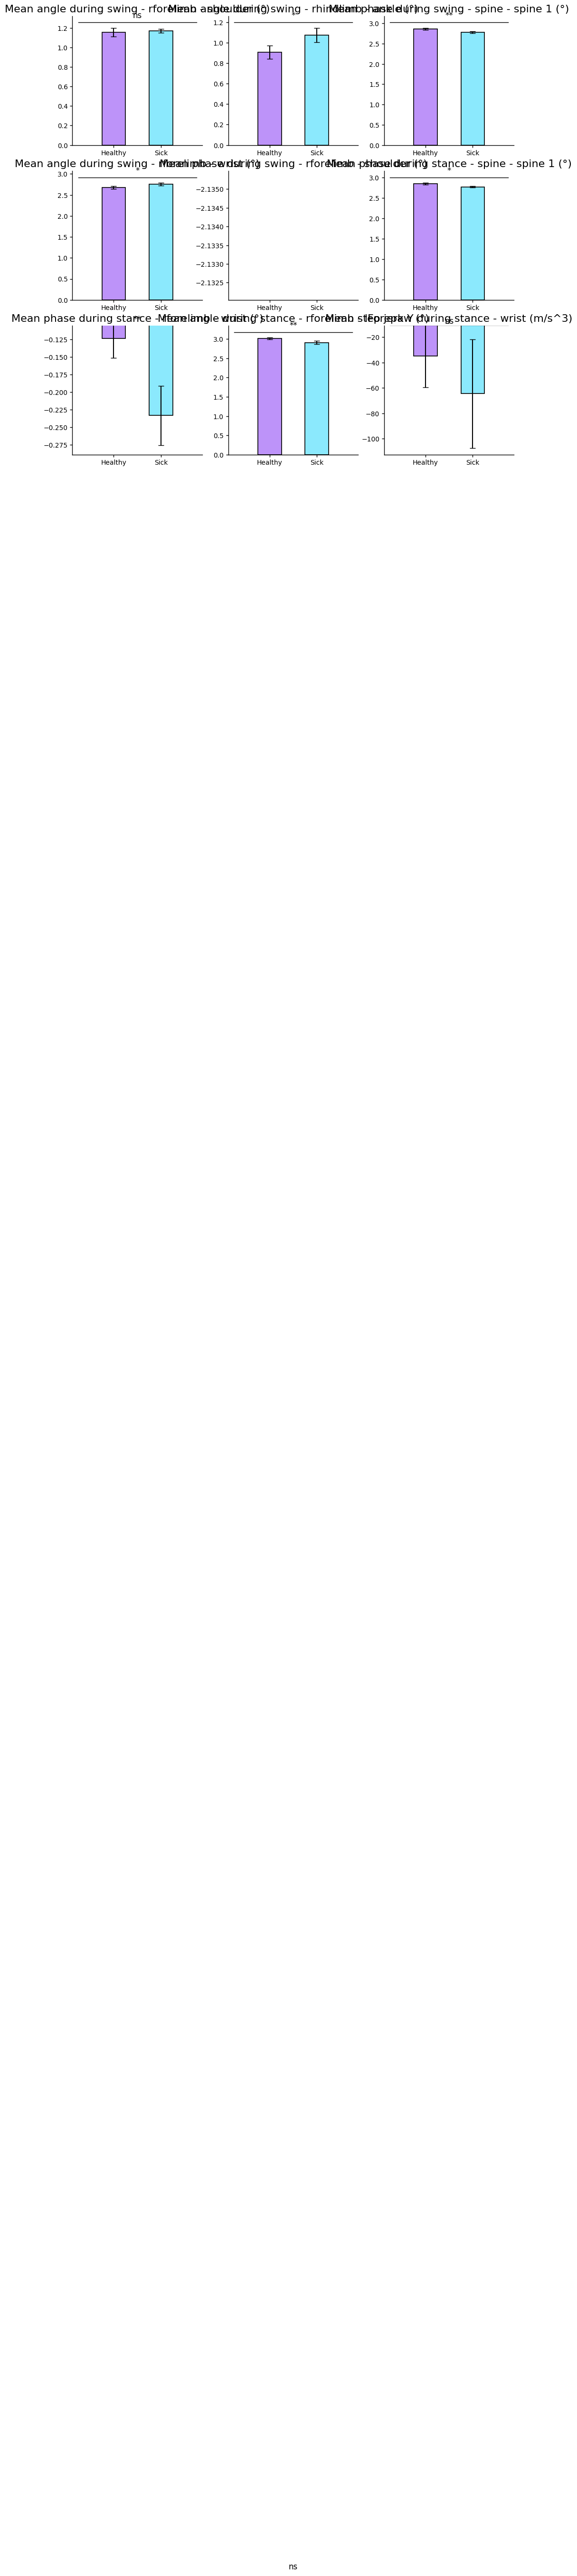

C:\Users\walid\AppData\Local\Temp\ipykernel_131384\792602219.py:77: UserWarning:

constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.



Figure saved to ./figures/NewEpilepsy\Validation\Healthy_vs_SCI_Forelimb_Steps_vs_Hindlimb.svg


In [553]:
## Test for equal variance using Levene's test
from scipy.stats import levene
# Perform Levene's test for the two distributions
levene_results = {}
for feature in foresteps_features_to_check + features_to_check_against:
    if feature in healthy_forelimb_mean_features.columns and feature in sick_forelimb_mean_features.columns:
        healthy_values = healthy_forelimb_mean_features[feature].dropna().values
        sick_values = sick_forelimb_mean_features[feature].dropna().values
        if len(healthy_values) > 0 and len(sick_values) > 0:
            stat, p_value = levene(healthy_values, sick_values)
            levene_results[feature] = {'statistic': stat, 'p-value': p_value}

# Convert results to DataFrame for better readability
levene_df = pd.DataFrame(levene_results).T
levene_df = levene_df.reset_index().rename(columns={'index': 'Feature'})
levene_df['Significant'] = levene_df['p-value'] < 0.05  # Mark significant results, which indicates unequal variance
print(levene_df)

## Perform t-test of healthy vs sick based on forelimb
t_test_results = defaultdict(dict)
total_features = foresteps_features_to_check + features_to_check_against
for feature in total_features:
    if feature in healthy_forelimb_mean_features.columns and feature in sick_forelimb_mean_features.columns:
        healthy_values = healthy_forelimb_mean_features[feature].dropna().values
        sick_values = sick_forelimb_mean_features[feature].dropna().values
        if len(healthy_values) > 0 and len(sick_values) > 0:
            t_stat, p_value = ttest_ind_from_stats(
                mean1=np.mean(healthy_values),
                std1=np.std(healthy_values, ddof=1),
                nobs1=len(healthy_values),
                mean2=np.mean(sick_values),
                std2=np.std(sick_values, ddof=1),
                nobs2=len(sick_values),
                equal_var=False  # Welch's t-test
            )
            t_test_results[feature]['healthy_mean'] = np.mean(healthy_values)
            t_test_results[feature]['sick_mean'] = np.mean(sick_values)
            t_test_results[feature]['healthy_std'] = np.std(healthy_values, ddof=1)
            t_test_results[feature]['sick_std'] = np.std(sick_values, ddof=1)
            t_test_results[feature]['t-statistic'] = t_stat
            t_test_results[feature]['p-value'] = p_value

# Convert results to DataFrame for better readability
t_test_df = pd.DataFrame(t_test_results).T
t_test_df = t_test_df.reset_index().rename(columns={'index': 'Feature'})
t_test_df['Significant'] = t_test_df['p-value'] < 0.05  # Mark significant results, which indicates a significant difference between healthy and sick mice
print(f"Number of healthy mice: {len(healthy_forelimb_mean_features)}")
print(f"Number of sick mice: {len(sick_forelimb_mean_features)}")
print(t_test_df)
# Plot the t-test results
plot_ttest_results_grid(t_test_df, healthy_forelimb_mean_features, sick_forelimb_mean_features, cols=3, filepath=os.path.join(FIGURES_DIR, 'Validation', 'Healthy_vs_SCI_Forelimb_Steps_vs_Hindlimb.svg'))

In [554]:
# Prepare subplots: rows = len(features_to_check), cols = len(features_to_check_against)
fig = make_subplots(
    rows=len(features_to_check), 
    cols=len(features_to_check_against),
    # subplot_titles=[
    #     f"{y} vs {x}" for y in features_to_check for x in features_to_check_against
    # ],
    horizontal_spacing=0.05,
    vertical_spacing=0.08,
    print_grid=False
)

for i, y_feat in enumerate(features_to_check):
    for j, x_feat in enumerate(features_to_check_against):
        if x_feat in healthy_mean_features.columns and y_feat in healthy_mean_features.columns:
            fig.add_trace(
                go.Scatter(
                    x=healthy_mean_features[x_feat],
                    y=healthy_mean_features[y_feat],
                    mode='markers',
                    marker=dict(size=SCATTER_SIZE, color='green', opacity=1, line=dict(width=SCATTER_LINE_WIDTH, color='black')),
                    name=f"{y_feat} vs {x_feat}",
                    showlegend=False
                ),
                row=i+1, col=j+1
            )
            # Linear regression for healthy group
            x = healthy_mean_features[x_feat].values
            y = healthy_mean_features[y_feat].values
            if len(x) > 1 and len(y) > 1:
                # Remove NaNs
                mask = ~np.isnan(x) & ~np.isnan(y)
                if mask.sum() > 1:
                    x_clean = x[mask]
                    y_clean = y[mask]
                    # Fit linear regression
                    coef = np.polyfit(x_clean, y_clean, 1)
                    x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
                    y_line = np.polyval(coef, x_line)
                    fig.add_trace(
                        go.Scatter(
                            x=x_line,
                            y=y_line,
                            mode='lines',
                            line=dict(color='red', width=2, dash='dash'),
                            showlegend=False
                        ),
                        row=i+1, col=j+1
                    )
                    if j + 1 == 3:
                        m = coef[0] * 100 if i + 1 != 6 else coef[0]
                        print(f"{HEALTHY_KEY} linear regression for {y_feat} vs {x_feat}: y = {m:.2f}x + {coef[1]:.2f}")
            fig.add_trace(
                go.Scatter(
                    x=sick_mean_features[x_feat],
                    y=sick_mean_features[y_feat],
                    mode='markers',
                    marker=dict(size=SCATTER_SIZE, color='yellow', opacity=1, line=dict(width=SCATTER_LINE_WIDTH, color='black')),
                    name=f"{y_feat} vs {x_feat}",
                    showlegend=False
                ),
                row=i+1, col=j+1
            )
            # Linear regression for healthy group
            x = sick_mean_features[x_feat].values
            y = sick_mean_features[y_feat].values
            if len(x) > 1 and len(y) > 1:
                # Remove NaNs
                mask = ~np.isnan(x) & ~np.isnan(y)
                if mask.sum() > 1:
                    x_clean = x[mask]
                    y_clean = y[mask]
                    # Fit linear regression
                    coef = np.polyfit(x_clean, y_clean, 1)
                    x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
                    y_line = np.polyval(coef, x_line)
                    fig.add_trace(
                        go.Scatter(
                            x=x_line,
                            y=y_line,
                            mode='lines',
                            line=dict(color='blue', width=2, dash='dash'),
                            showlegend=False
                        ),
                        row=i+1, col=j+1
                    )
                    if j + 1 == 3:
                        print(f"{SICK_KEY} linear regression for {y_feat} vs {x_feat}: y = {coef[0]:.2f}x + {coef[1]:.2f}")
        fig.update_xaxes(title_text=x_feat, row=i+1, col=j+1)
        fig.update_yaxes(title_text=y_feat, row=i+1, col=j+1)

fig.update_layout(
    height=300*len(features_to_check), 
    width=350*len(features_to_check_against),
    title_text=f"Mean Features comparison: {HEALTHY_KEY} (green) vs {SICK_KEY} (yellow) hindlimb Features",
    template="plotly_white"
)
print(f"Number of healthy mice: {len(healthy_mean_features['Mouse'].unique())}")
print(f'Number of unhealthy mice: {len(sick_mean_features['Mouse'].unique())}')
fig.show()
fig.write_image(os.path.join(os.path.join(FIGURES_DIR, 'Validation'), f'{HEALTHY_KEY}_vs_{SICK_KEY}_Mean_Hindlimb_Features.svg'), format='svg')

MUNonTreated linear regression for Mean angle during swing - rforelimb - shoulder (°) vs Mean angle during stance - rforelimb - lForepaw (°): y = 113.54x + -2.26
WTNonTreated linear regression for Mean angle during swing - rforelimb - shoulder (°) vs Mean angle during stance - rforelimb - lForepaw (°): y = 0.07x + 0.59
MUNonTreated linear regression for Mean angle during swing - rhindlimb - ankle (°) vs Mean angle during stance - rforelimb - lForepaw (°): y = -74.10x + 2.65
WTNonTreated linear regression for Mean angle during swing - rhindlimb - ankle (°) vs Mean angle during stance - rforelimb - lForepaw (°): y = 0.29x + 0.20
MUNonTreated linear regression for Mean phase during swing - spine - spine 1 (°) vs Mean angle during stance - rforelimb - lForepaw (°): y = -53.90x + 4.25
WTNonTreated linear regression for Mean phase during swing - spine - spine 1 (°) vs Mean angle during stance - rforelimb - lForepaw (°): y = 0.08x + 2.57
MUNonTreated linear regression for Mean angle during sw

('Mean angle during swing - rforelimb - shoulder (°)', 'Mean angle during swing - rhindlimb - ankle (°)', 'Mean phase during swing - spine - spine 1 (°)', 'Mean angle during swing - rforelimb - wrist (°)', 'Mean phase during swing - rforelimb - shoulder (°)', 'Mean phase during stance - spine - spine 1 (°)', 'Mean phase during stance - rforelimb - wrist (°)', 'Mean angle during stance - rforelimb - lForepaw (°)', 'Mean step jerk Y during stance - wrist (m/s^3)', 'Mean angle excursion - rforelimb - wrist (°))')
10 5 5
Number of healthy mice: 3
Number of sick mice: 8
                                             Feature  healthy_mean  sick_mean  \
0  Mean angle during swing - rforelimb - shoulder...      0.700622   0.769696   
1    Mean angle during swing - rhindlimb - ankle (°)      0.720770   0.923293   
2      Mean phase during swing - spine - spine 1 (°)      2.844661   2.764234   
3    Mean angle during swing - rforelimb - wrist (°)      1.966053   2.098875   
4  Mean phase during sw

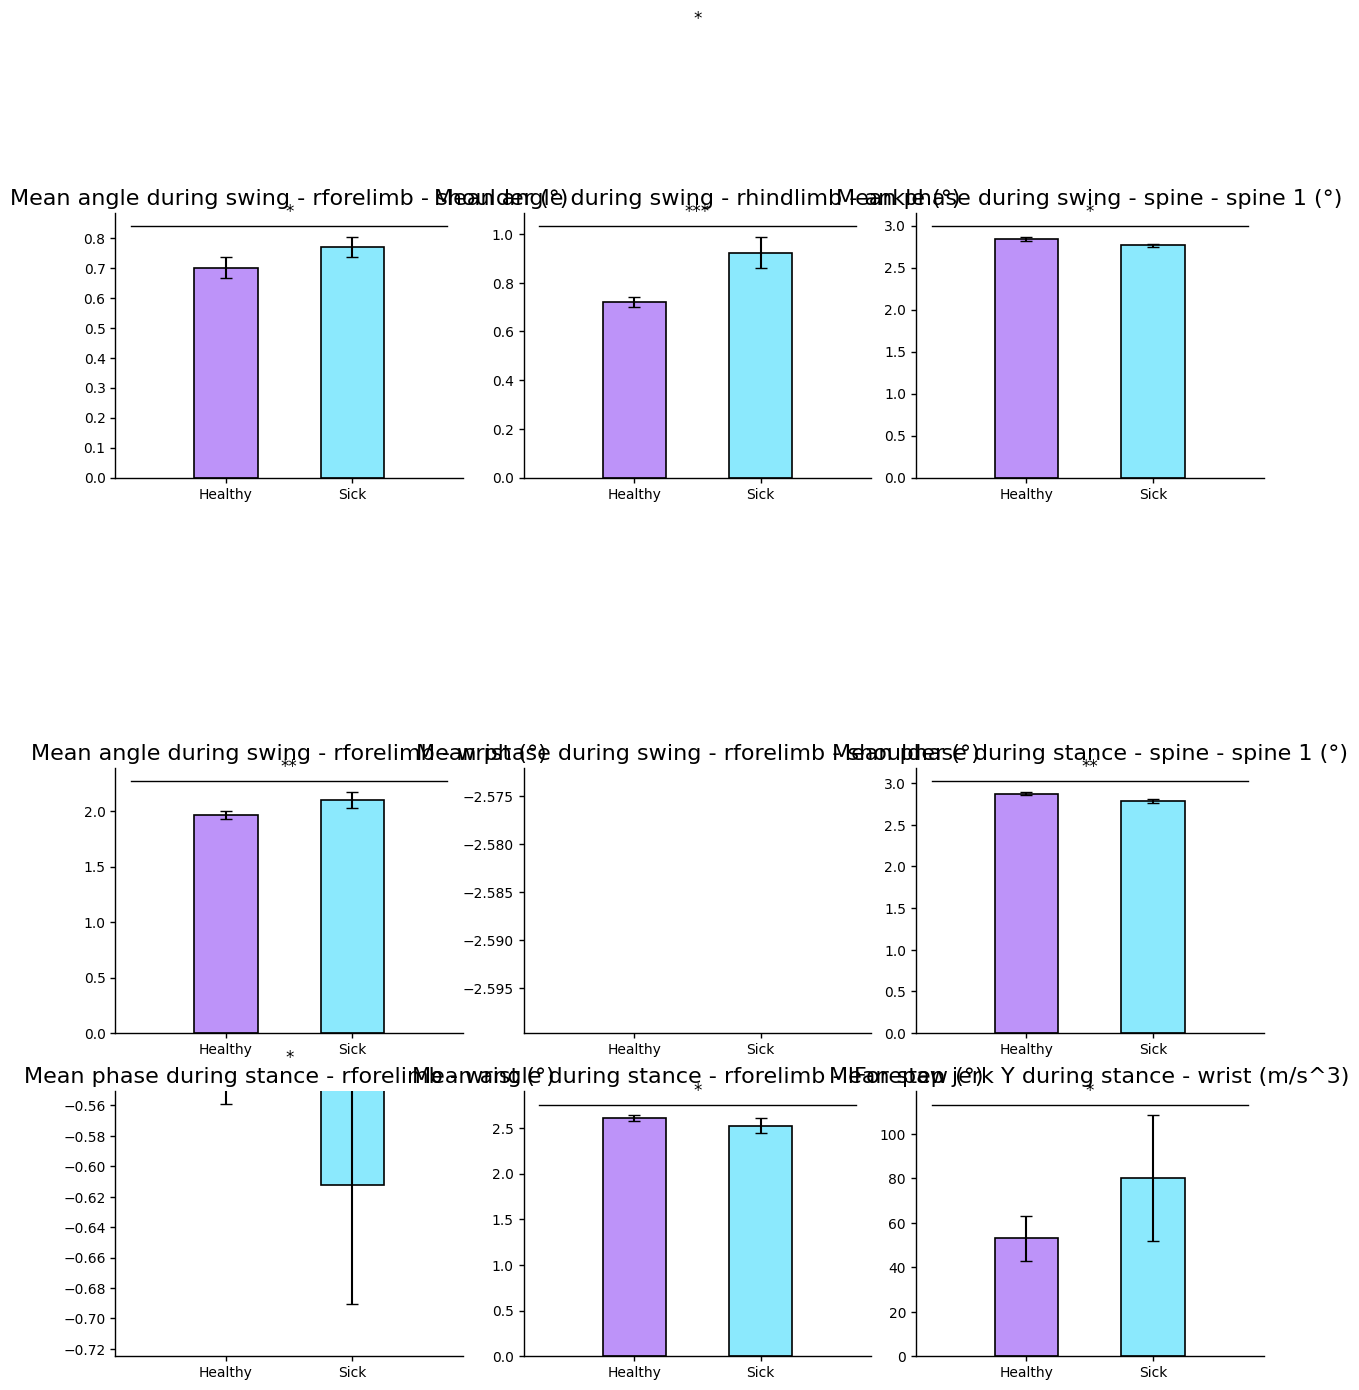

In [555]:
## Perform t-test of healthy vs sick for left and right mice
t_test_results_lr = defaultdict(dict)
total_features_lr = features_to_check + features_to_check_against
print(total_features_lr)
print(len(total_features_lr), len(features_to_check), len(features_to_check_against))

for feature in total_features_lr:
    if feature in healthy_mean_features_lr.columns and feature in sick_mean_features_lr.columns:
        healthy_values = healthy_mean_features_lr[feature].dropna().values
        sick_values = sick_mean_features_lr[feature].dropna().values
        if len(healthy_values) > 0 and len(sick_values) > 0:
            t_stat, p_value = ttest_ind_from_stats(
                mean1=np.mean(healthy_values),
                std1=np.std(healthy_values, ddof=1),
                nobs1=len(healthy_values),
                mean2=np.mean(sick_values),
                std2=np.std(sick_values, ddof=1),
                nobs2=len(sick_values),
                equal_var=False  # Welch's t-test
            )
            t_test_results_lr[feature]['healthy_mean'] = np.mean(healthy_values)
            t_test_results_lr[feature]['sick_mean'] = np.mean(sick_values)
            t_test_results_lr[feature]['healthy_std'] = np.std(healthy_values, ddof=1)
            t_test_results_lr[feature]['sick_std'] = np.std(sick_values, ddof=1)
            t_test_results_lr[feature]['t-statistic'] = t_stat
            t_test_results_lr[feature]['p-value'] = p_value

# Convert results to DataFrame for better readability
t_test_df_lr = pd.DataFrame(t_test_results_lr).T
t_test_df_lr = t_test_df_lr.reset_index().rename(columns={'index': 'Feature'})
t_test_df_lr['Significant'] = t_test_df_lr['p-value'] < 0.05  # Mark significant results, which indicates a significant difference between healthy and sick mice
print(f"Number of healthy mice: {len(healthy_mean_features_lr)}")
print(f"Number of sick mice: {len(sick_mean_features_lr)}")
print(t_test_df_lr)

# Plot the t-test results for left and right mice
plot_ttest_results_grid(t_test_df_lr, healthy_mean_features_lr, sick_mean_features_lr, cols=3)

In [556]:
## Perform t-test to see if on right sided runs healthy is different from sick
t_test_results_r = defaultdict(dict)
total_features_r = features_to_check + features_to_check_against
for feature in total_features_r:
    if feature in healthy_mean_features_r.columns and feature in sick_mean_features_r.columns:
        healthy_values = healthy_mean_features_r[feature].dropna().values
        sick_values = sick_mean_features_r[feature].dropna().values
        if len(healthy_values) > 0 and len(sick_values) > 0:
            t_stat, p_value = ttest_ind_from_stats(
                mean1=np.mean(healthy_values),
                std1=np.std(healthy_values, ddof=1),
                nobs1=len(healthy_values),
                mean2=np.mean(sick_values),
                std2=np.std(sick_values, ddof=1),
                nobs2=len(sick_values),
                equal_var=False  # Welch's t-test
            )
            t_test_results_r[feature]['healthy_mean'] = np.mean(healthy_values)
            t_test_results_r[feature]['sick_mean'] = np.mean(sick_values)
            t_test_results_r[feature]['healthy_std'] = np.std(healthy_values, ddof=1)
            t_test_results_r[feature]['sick_std'] = np.std(sick_values, ddof=1)
            t_test_results_r[feature]['t-statistic'] = t_stat
            t_test_results_r[feature]['p-value'] = p_value

# Convert results to DataFrame for better readability
t_test_df_r = pd.DataFrame(t_test_results_r).T
t_test_df_r = t_test_df_r.reset_index().rename(columns={'index': 'Feature'})
t_test_df_r['Significant'] = t_test_df_r['p-value'] < 0.05  # Mark significant results, which indicates a significant difference between healthy and sick mice
print(f"Number of healthy mice: {len(healthy_mean_features_r)}")
print(f"Number of sick mice: {len(sick_mean_features_r)}")
print(t_test_df_r)

# Plot the t-test results for right sided runs
plot_ttest_results_grid(t_test_df_r, healthy_mean_features_r, sick_mean_features_r, cols=3)

KeyError: 'p-value'

Number of healthy mice: 3
Number of sick mice: 8
                                             Feature  healthy_mean  sick_mean  \
0  Mean angle during swing - rforelimb - shoulder...      0.700622   0.769696   
1    Mean angle during swing - rhindlimb - ankle (°)      0.720770   0.923293   
2      Mean phase during swing - spine - spine 1 (°)      2.844661   2.764234   
3    Mean angle during swing - rforelimb - wrist (°)      1.966053   2.098875   
4  Mean phase during swing - rforelimb - shoulder...     -2.440971  -2.371896   
5     Mean phase during stance - spine - spine 1 (°)      2.872541   2.785279   
6   Mean phase during stance - rforelimb - wrist (°)     -0.529825  -0.612572   
7  Mean angle during stance - rforelimb - lForepa...      2.608648   2.526179   
8     Mean step jerk Y during stance - wrist (m/s^3)     53.125443  79.985804   

   healthy_std   sick_std  t-statistic   p-value  Significant  
0     0.034944   0.033622    -2.949827  0.049406         True  
1     0.0209

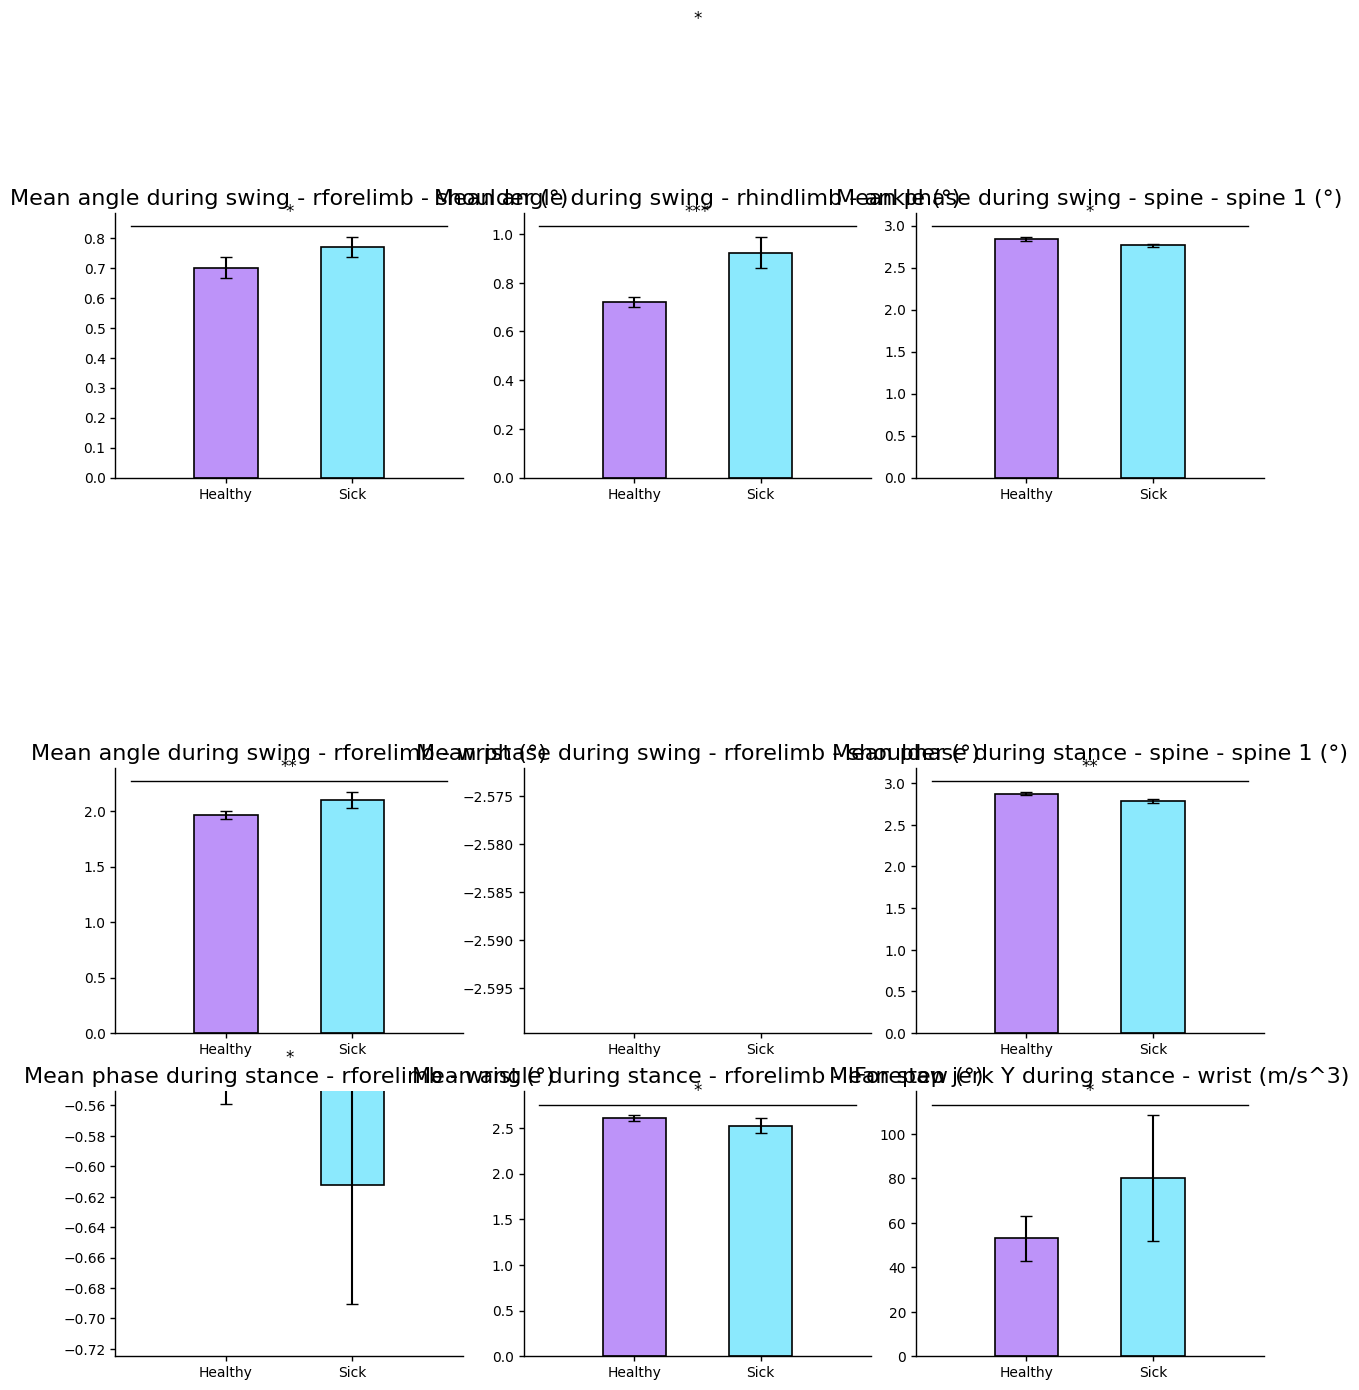

In [557]:
## Perform t-test of healthy left sided runs healthy vs sick
t_test_results_l = defaultdict(dict)
total_features_l = features_to_check + features_to_check_against
for feature in total_features_l:
    if feature in healthy_mean_features_lr.columns and feature in sick_mean_features_lr.columns:
        healthy_values = healthy_mean_features_lr[feature].dropna().values
        sick_values = sick_mean_features_lr[feature].dropna().values
        if len(healthy_values) > 0 and len(sick_values) > 0:
            t_stat, p_value = ttest_ind_from_stats(
                mean1=np.mean(healthy_values),
                std1=np.std(healthy_values, ddof=1),
                nobs1=len(healthy_values),
                mean2=np.mean(sick_values),
                std2=np.std(sick_values, ddof=1),
                nobs2=len(sick_values),
                equal_var=False  # Welch's t-test
            )
            t_test_results_l[feature]['healthy_mean'] = np.mean(healthy_values)
            t_test_results_l[feature]['sick_mean'] = np.mean(sick_values)
            t_test_results_l[feature]['healthy_std'] = np.std(healthy_values, ddof=1)
            t_test_results_l[feature]['sick_std'] = np.std(sick_values, ddof=1)
            t_test_results_l[feature]['t-statistic'] = t_stat
            t_test_results_l[feature]['p-value'] = p_value

# Convert results to DataFrame for better readability
t_test_df_l = pd.DataFrame(t_test_results_l).T
t_test_df_l = t_test_df_l.reset_index().rename(columns={'index': 'Feature'})
t_test_df_l['Significant'] = t_test_df_l['p-value'] < 0.05  # Mark significant results, which indicates a significant difference between healthy and sick mice
print(f"Number of healthy mice: {len(healthy_mean_features_lr)}")
print(f"Number of sick mice: {len(sick_mean_features_lr)}")
print(t_test_df_l)

# Plot the t-test results for left sided runs
plot_ttest_results_grid(t_test_df_l, healthy_mean_features_lr, sick_mean_features_lr, cols=3)

In [558]:
## Print the ratio between stance and swing durations 
healthy_stance_ratio = healthy_mean_features['Mean stance duration (s)'].mean() / healthy_mean_features['Mean step duration (s)'].mean()
healthy_swing_ratio = healthy_mean_features['Mean swing duration (s)'].mean() / healthy_mean_features['Mean step duration (s)'].mean()
healthy_step_duration = healthy_mean_features['Mean step duration (s)'].mean()
healthy_step_duration_std = healthy_mean_features['Mean step duration (s)'].std()

sick_stance_ratio = sick_mean_features['Mean stance duration (s)'].mean() / sick_mean_features['Mean step duration (s)'].mean()
sick_swing_ratio = sick_mean_features['Mean swing duration (s)'].mean() / sick_mean_features['Mean step duration (s)'].mean()
sick_step_duration = sick_mean_features['Mean step duration (s)'].mean()

print(f"Healthy mean stance duration ratio: {healthy_stance_ratio:.2f}, mean swing duration: {healthy_swing_ratio:.2f}, mean step duration: {healthy_step_duration:.2f} ± {healthy_step_duration_std:.2f}")
print(f"Sick mean stance duration ratio: {sick_stance_ratio:.2f}, mean swing duration: {sick_swing_ratio:.2f}, mean step duration: {sick_step_duration:.2f}")

Healthy mean stance duration ratio: 0.55, mean swing duration: 0.45, mean step duration: 0.22 ± 0.03
Sick mean stance duration ratio: 0.55, mean swing duration: 0.45, mean step duration: 0.21


In [559]:
## Pint the average phase excursions and angle excursions
phase_excursion_cols = [col for col in healthy_mean_features.columns if 'phase excursion' in col.lower() and 'std' not in col.lower()]
angle_excursion_cols = [col for col in healthy_mean_features.columns if 'angle excursion' in col.lower() and 'std' not in col.lower()]

# for col in phase_excursion_cols:
#     healthy_mean = healthy_mean_features[col].mean()
#     healthy_std = healthy_mean_features[col].std() / np.sqrt(len(healthy_mean_features))
#     healthy_sem = healthy_mean_features[col].std() / np.sqrt(len(healthy_mean_features))
    
#     print(f"{col}: Healthy mean = {healthy_mean:.2f} ± {healthy_sem:.2f}, std = {healthy_std:.2f}")

# for col in angle_excursion_cols:
#     healthy_mean = healthy_mean_features[col].mean()
#     healthy_sem = healthy_mean_features[col].std() / np.sqrt(len(healthy_mean_features))
#     sick_mean = sick_mean_features[col].mean()
#     sick_sem = sick_mean_features[col].std() / np.sqrt(len(sick_mean_features))
    
#     print(f"{col}: Healthy mean = {healthy_mean:.2f} ± {healthy_sem:.2f}, Sick mean = {sick_mean:.2f} ± {sick_sem:.2f}")

hip_col = [col for col in phase_excursion_cols if 'hip' in col.lower()]
knee_col = [col for col in phase_excursion_cols if 'knee' in col.lower()]
finger_col = [col for col in phase_excursion_cols if 'paw' in col.lower()]
cols_list = [hip_col, knee_col, finger_col]
cols = ('hip', 'knee', 'paw')

print('number of healthy mean features:', len(healthy_mean_features))
print('number of sick mean features:', len(sick_mean_features))
for bp, col in zip(cols, cols_list):
    healthy_mean = healthy_mean_features[col].mean()
    healthy_std = healthy_mean_features[col].std()
    healthy_sem = healthy_std / np.sqrt(len(healthy_mean_features))
    sick_mean = sick_mean_features[col].mean()
    sick_std = sick_mean_features[col].std()
    sick_sem = sick_std / np.sqrt(len(sick_mean_features))
    
    print("---------")
    print(f"{bp} phase excursion: Healthy mean = {healthy_mean.values} ± {healthy_std.values} sem = {healthy_sem.values} \n"
          f"Sick mean = {sick_mean.values} ± {sick_std.values} sem = {sick_sem.values}")


number of healthy mean features: 3
number of sick mean features: 8
---------
hip phase excursion: Healthy mean = [67.99107224] ± [3.22095519] sem = [1.85961935] 
Sick mean = [66.27974556] ± [3.71234251] sem = [1.31251128]
---------
knee phase excursion: Healthy mean = [60.2323232] ± [2.45594206] sem = [1.41793881] 
Sick mean = [66.32461355] ± [5.31854857] sem = [1.88039088]
---------
paw phase excursion: Healthy mean = [123.17248068] ± [1.92152101] sem = [1.10939067] 
Sick mean = [117.04437109] ± [6.40662323] sem = [2.26508337]


In [560]:
from scipy.stats import ttest_ind_from_stats

# Bellardita values (mean ± SD, n = 10 steps, for trot gait)
bellardita_hip_mean = 62
bellardita_hip_sd = 2
bellardita_knee_mean = 80
bellardita_knee_sd = 2
bellardita_paw_mean = 92
bellardita_paw_sd = 3
n_bellardita = 10

# Your values (mean ± SD, n = 3932)
your_hip_mean = 63.00248912
your_hip_sd = 8.78260217
your_knee_mean = 74.83686144
your_knee_sd = 4.06348561
your_paw_mean = 121.28590795
your_paw_sd = 14.18690368
n_your = 95

# Perform t-tests
t_hip, p_hip = ttest_ind_from_stats(your_hip_mean, your_hip_sd, n_your,
                                    bellardita_hip_mean, bellardita_hip_sd, n_bellardita)

t_knee, p_knee = ttest_ind_from_stats(your_knee_mean, your_knee_sd, n_your,
                                      bellardita_knee_mean, bellardita_knee_sd, n_bellardita)

t_paw, p_paw = ttest_ind_from_stats(your_paw_mean, your_paw_sd, n_your,
                                    bellardita_paw_mean, bellardita_paw_sd, n_bellardita)

# Print results
print("Hip t-test: t = {:.3f}, p = {:.3e}".format(t_hip, p_hip))
if p_hip < 0.05:
    print(f"Hip phase excursion is significantly different from Bellardita's values. with a confidence level of {1 - p_hip:.2f}")
else:
    print("Hip phase excursion is not significantly different from Bellardita's values.")
print("Knee t-test: t = {:.3f}, p = {:.3e}".format(t_knee, p_knee))
if p_knee < 0.05:
    print(f"Knee phase excursion is significantly different from Bellardita's values. with a confidence level of {1 - p_knee:.2f}")
else:
    print("Knee phase excursion is not significantly different from Bellardita's values.")
print("Paw t-test: t = {:.3f}, p = {:.3e}".format(t_paw, p_paw))
if p_paw < 0.05:
    print(f"Paw phase excursion is significantly different from Bellardita's values. with a confidence level of {1 - p_paw:.2f}")
else:
    print("Paw phase excursion is not significantly different from Bellardita's values.")

Hip t-test: t = 0.359, p = 7.207e-01
Hip phase excursion is not significantly different from Bellardita's values.
Knee t-test: t = -3.955, p = 1.407e-04
Knee phase excursion is significantly different from Bellardita's values. with a confidence level of 1.00
Paw t-test: t = 6.486, p = 3.120e-09
Paw phase excursion is significantly different from Bellardita's values. with a confidence level of 1.00


In [561]:
fig = px.scatter_3d(
    healthy_mean_features,
    x='Mean stance duration (s)',
    y='Mean swing duration (s)',
    z='Mean step velocity X at stance - lHindpaw (m/s)',
    color='Mouse',
    hover_name='Mouse',
    title="Healthy Mean Features: Stance Duration vs Swing Duration vs Velocity",
    labels={
        'Mean stance duration (s)': 'Average Stance Duration (s)',
        'Mean swing duration (s)': 'Average Swing Duration (s)',
        'Mean step velocity X at stance - lHindpaw (m/s)': 'Average Step Velocity X at Stance (m/s)'
    },
    template="plotly_white"
)
fig.update_traces(marker=dict(size=3, line=dict(width=SCATTER_LINE_WIDTH, color='black'), color = 'blue'))
fig.update_layout(
    legend=dict(font=dict(size=LEGEND_FONT_SIZE)),
    title=dict(font=dict(size=TITLE_FONT_SIZE)),
    scene=dict(
        xaxis_title='Average Stance Duration (s)',
        yaxis_title='Average Swing Duration (s)',
        zaxis_title='Average Step Velocity X at Stance (m/s)',
        xaxis=dict(tickfont=dict(size=AXIS_FONT_SIZE)),
        yaxis=dict(tickfont=dict(size=AXIS_FONT_SIZE)),
        zaxis=dict(tickfont=dict(size=AXIS_FONT_SIZE)),
    )
)
fig.show()

In [562]:
# Linear regression for healthy group with intercept fixed at 0
x = healthy_mean_features[x_feat].values
y = healthy_mean_features[y_feat].values
if len(x) > 1 and len(y) > 1:
    # Remove NaNs
    mask = ~np.isnan(x) & ~np.isnan(y)
    if mask.sum() > 1:
        x_clean = x[mask]
        y_clean = y[mask]
        
        # Fit linear regression with intercept=0
        # Use np.linalg.lstsq for regression through origin
        slope = np.sum(x_clean * y_clean) / np.sum(x_clean * x_clean)
        
        # Alternative using sklearn:
        # from sklearn.linear_model import LinearRegression
        # model = LinearRegression(fit_intercept=False)
        # model.fit(x_clean.reshape(-1, 1), y_clean)
        # slope = model.coef_[0]
        
        x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
        y_line = slope * x_line  # No intercept term
        
        fig.add_trace(
            go.Scatter(
                x=x_line,
                y=y_line,
                mode='lines',
                line=dict(color='red', width=2, dash='dash'),
                showlegend=False
            ),
            row=i+1, col=j+1
        )
        if j + 1 == 3:
            print(f"Healthy linear regression for {y_feat} vs {x_feat}: y = {slope:.2f}x")

KeyError: 'Mean angle excursion - rforelimb - wrist (°))'

In [ ]:
### Training block
model = None
if BEST_MODEL_PATH:
    model = load_model(model_path=BEST_MODEL_PATH, input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM)
    load_and_plot_losses(losses_file=BEST_LOSS_PATH,
                        title_font_size=TITLE_FONT_SIZE,
                        axis_title_font_size=AXIS_TITLE_FONT_SIZE,
                        legend_font_size=LEGEND_FONT_SIZE)
else:
    model, train_losses, val_losses = train_model(
        step_tensor=step_tensor,
        lengths=lengths,
        input_dim=INPUT_DIM,
        hidden_dim=HIDDEN_DIM,
        latent_dim=LATENT_DIM,
        batch_size=BATCH_SIZE,
        num_epochs=NUM_EPOCHS,
        lr=LR,
        patience=PATIENCE,
        min_delta=MIN_DELTA,
        models_dir=MODELS_DIR
    )
    save_model_losses(train_losses, val_losses, figures_dir=FIGURES_DIR,
                        title_font_size=TITLE_FONT_SIZE,
                        axis_title_font_size=AXIS_FONT_SIZE,
                        legend_font_size=LEGEND_FONT_SIZE)

assert model is not None, "Model training failed or no model was loaded."

In [ ]:
### Evaluate the model on pathological steps
selected_steps = [
    s for s in segmented_hindsteps 
    if SIDE_KEY[0] in s["mouse"] 
]

step_tensor_all, lengths_all = steps_to_tensor(selected_steps, scaler)

## Get all embeddings for selected steps
model.eval()
with torch.no_grad():
    x_hat, mu_t, logvar_t  = model(step_tensor_all, lengths_all)  # (B, T, F), (B, T, L), (B, T, L)
    z_summary = mu_t.mean(dim=1)  # → shape: (B, L)

reducer = UMAP(random_state=42, n_components=3)
embedding = reducer.fit_transform(z_summary.cpu().numpy())  # shape: (B, 3)

# Convert each step’s latent sequence to list of (T_i, L)
# mu_t_masked = [
#     mu_t[i, :lengths_all[i]].cpu().numpy()  # shape: (T_i, L)
#     for i in range(mu_t.shape[0])
# ]

# Stack all latent vectors across all steps
# all_latents = np.concatenate(mu_t_masked, axis=0)  # shape: (sum of T_i, L)

# # Fit UMAP
# umap_coords = UMAP(n_components=3, random_state=42).fit_transform(all_latents)

# ## Now split the coordinates back by original steps
# # for each step, have all the umap coordinates
# umap_split = []
# idx = 0
# for i in range(len(mu_t_masked)):
#     length = mu_t_masked[i].shape[0]
#     umap_split.append(umap_coords[idx:idx + length])  # shape: (T_i, 3)
#     idx += length

In [ ]:
datasets = sorted(set(s["group"] for s in selected_steps))
color_map = {ds: color for ds, color in zip(datasets, plotly.colors.qualitative.Plotly)}
# if pre is in group, use the first color, otherwise use the second color
for i, ds in enumerate(datasets):
    if HEALTHY_KEY in ds:
        color_map[ds] = plotly.colors.qualitative.Plotly[0]
    else:
        color_map[ds] = plotly.colors.qualitative.Plotly[1]

fig = go.Figure()
legend_shown = defaultdict(bool)

for i, (x, y, z) in enumerate(embedding):
    step_meta = selected_steps[i]
    dataset = step_meta["group"]
    mouse = step_meta["mouse"]
    run = step_meta["run"]
    color = color_map.get(dataset, "gray")
    show_legend = not legend_shown[dataset]
    legend_shown[dataset] = True

    fig.add_trace(go.Scatter3d(
        x=[x], y=[y], z=[z],
        mode='markers',
        name=dataset if show_legend else None,
        legendgroup=dataset,
        showlegend=show_legend,
        marker=dict(size=SCATTER_SIZE, color=color, line=dict(width=SCATTER_LINE_WIDTH, color='black')),
        hoverinfo='text',
        text=[f"{dataset} | {mouse} | run={run}"]
    ))

fig.update_layout(
    title="Latent Trajectories Over Time by Dataset",
    scene=dict(
        xaxis_title='UMAP1',
        yaxis_title='UMAP2',
        zaxis_title='UMAP3'
    ),
    legend=dict(title="Dataset"),
    width=900,
    height=700,
    template='plotly_white'
)

fig.show()

In [ ]:
## TODO: make the 3D plot with trajectories for both pre and post sci
sample_idx = torch.randperm(mu_t.shape[0])[:100]
mu_t_sample = mu_t[sample_idx]
lengths_sample = lengths_all[sample_idx]
selected_sample = [selected_steps[i] for i in sample_idx.tolist()]

mu_t = mu_t_sample

B, T, L = mu_t.shape

# Flatten all time steps for UMAP
mu_t_flat = mu_t.reshape(-1, L).cpu().numpy()  # (B*T, L)

# Reduce L → 3 using UMAP
embedding_flat = reducer.fit_transform(mu_t_flat)  # (B*T, 3)

# Reshape embedding back to (B, T, 3)
embedding_3d = embedding_flat.reshape(B, T, 3)

print("Moving to 3D plotting...")

# Plot each step as a 3D trajectory
fig = go.Figure()
legend_shown = defaultdict(bool)

for i in range(B):
    emb = embedding_3d[i, :lengths_all[i]]  # shape: T × 3
    meta = selected_steps[i]
    dataset = meta["group"]
    mouse = meta["mouse"]
    run = meta["run"]
    color = color_map.get(dataset, "gray")
    show_legend = not legend_shown[dataset]
    legend_shown[dataset] = True

    fig.add_trace(go.Scatter3d(
        x=emb[:, 0],
        y=emb[:, 1],
        z=emb[:, 2],
        mode='lines+markers',
        name=dataset if show_legend else None,
        legendgroup=dataset,
        showlegend=show_legend,
        marker=dict(size=SCATTER_SIZE, color=color, line=dict(width=SCATTER_LINE_WIDTH, color='black')),
        hoverinfo='text',
        text=[f"{dataset} | {mouse} | run={run} | t={t}" for t in range(len(emb))]
    ))

fig.update_layout(
    title="Latent Trajectories Over Time (per Step)",
    scene=dict(
        xaxis_title='UMAP1',
        yaxis_title='UMAP2',
        zaxis_title='UMAP3'
    ),
    legend=dict(title="Dataset"),
    width=900,
    height=700,
    template='plotly_white'
)

fig.show()

NameError: name 'mu_t' is not defined

In [ ]:
def plot_timewise_umap_trajectories(segmented_hindsteps, scaler):
    """
    Plot UMAP projection of all timepoints in each step.
    Each step becomes a trajectory (line) in 3D UMAP space.
    Mice from the same dataset (e.g., 'pre', 'post') share color and legend.
    """
    from collections import defaultdict

    filtered_steps = [s for s in segmented_hindsteps if SIDE_KEY[0] in s["mouse"]]

    step_id = 0
    timepoints = []
    metadata = []

    for s in filtered_steps:
        arr = scaler.transform(s["step"].values)  # (T, D)
        for t in range(arr.shape[0]):
            timepoints.append(arr[t])
            metadata.append({
                "step_id": step_id,
                "t": t,
                "mouse": s["mouse"],
                "group": s["group"],
                "run": s["run"]
            })
        step_id += 1

    X = np.stack(timepoints)
    umap_coords = UMAP(n_components=3, random_state=42).fit_transform(X)

    umap_df = pd.DataFrame(umap_coords, columns=["UMAP1", "UMAP2", "UMAP3"])
    umap_df = pd.concat([umap_df, pd.DataFrame(metadata)], axis=1)

    datasets = sorted(umap_df["group"].unique())
    color_map = {ds: color for ds, color in zip(datasets, plotly.colors.qualitative.Plotly)}

    fig = go.Figure()
    legend_shown = defaultdict(bool)

    for step_id, group in umap_df.groupby("step_id"):
        dataset = group["group"].iloc[0]
        color = color_map[dataset]
        show_legend = not legend_shown[dataset]
        legend_shown[dataset] = True

        fig.add_trace(go.Scatter3d(
            x=group["UMAP1"],
            y=group["UMAP2"],
            z=group["UMAP3"],
            mode="lines+markers",
            line=dict(color=color, width=2),
            marker=dict(size=3, color=color),
            name=dataset,
            legendgroup=dataset,
            showlegend=show_legend,
            text=[f"{group['mouse'].iloc[0]} | run={r} | t={t}" for r, t in zip(group["run"], group["t"])]
        ))

    fig.update_layout(
        title="Time-Resolved UMAP of Step Dynamics by Dataset",
        scene=dict(
            xaxis_title="UMAP1",
            yaxis_title="UMAP2",
            zaxis_title="UMAP3"
        ),
        legend=dict(title="Dataset", font=dict(size=12)),
        width=900,
        height=700,
        template="plotly_white"
    )

    fig.show()

# Usage:
plot_timewise_umap_trajectories(segmented_hindsteps, scaler)

c:\Users\walid\Desktop\Work\DataAnalysis\MScThesis\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

